<a href="https://colab.research.google.com/github/lapidesd/wetted_channels_from_space/blob/main/Colab_notebooks/wetted_channel_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import math
import matplotlib.ticker as ticker
import matplotlib
%config InlineBackend.figure_format='retina'

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load data


In [384]:
site = 'Ramsey'

In [557]:
# load imagery data
if site=='Ramsey':
    df = pd.read_csv('../data/'+site+'/processed_assumptions/processed_with_dates_and_assumptions.csv')
df['date'] = pd.to_datetime(df.date)
df['date'] = df.date.dt.date
df = df.groupby(['x','y','date']).first().reset_index()

#load hydro data
hydro = pd.read_csv('../data/'+site+'/'+site+'HydroData.csv')
hydro['Unnamed: 0'] = pd.to_datetime(hydro['Unnamed: 0'])
hydro.set_index('Unnamed: 0',inplace=True)

# load imagery metadata
metad = pd.read_csv('../data/'+site+'/'+site+'_imagery_metadata.csv')
metad['acquired'] = pd.to_datetime(metad.acquired)
metad['doy'] = metad.acquired.dt.dayofyear
metad['time'] = metad.acquired.dt.hour
metad['date'] = metad.acquired.dt.date
metad = metad.groupby('date').first().reset_index()

# load imagery summary data values
imagd = pd.read_csv('../data/'+site+'/'+site+'_imagery_summary_values.csv')
imagd['date'] = pd.to_datetime(imagd['date'],format='%Y%m%d')
imagd['date'] = imagd.date.dt.date
imagd.drop(columns='Unnamed: 0',inplace=True)
imagd = imagd.set_index('date').sort_index().reset_index().groupby('date').first().reset_index()

## Normalize data values

In [559]:
df = df.merge(imagd,on='date')

In [560]:
for band in ['blue','green','red','NIR']:
    if band=='NIR':
        band1 = 'nir'
    else:
        band1 = band
    df[band] = (df[band]-df[band1+'1'].median())/(df[band1+'99'].median()-df[band1+'1'].median())

# Random Forest

## make estimator and predictor dataframes, run model

In [561]:
df = df.merge(metad,on='date')

In [562]:
features = ['blue', 'green', 'red', 'NIR', 'NDWI',
#            'satellite_azimuth',
#             'sun_azimuth','sun_elevation',
#             'view_angle',
           ]
X = df[features]
X = X.fillna(X.median())
df['wet'] = np.where(df.wetdry=='wet',1,0)
Y = df['wet']
print('Depth of binary tree on num samples is %.0f'%np.log2(np.shape(X)[0]))

Depth of binary tree on num samples is 15


# Hyperparameter search on max_depth
---

Default parameters (maxdepth = None) are likely the best option as hyperparameter search finds optimal $\mathrm{maxdepth}=30 \gg log_2(N)$, where $N$ is the number of samples. For simplicity, we stick with default hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

param_grid = {
    'max_depth': [50,75,100,125,150],#[3, 6, 9, 15, 18, 20, 30, 50],
}

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=42)

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid, n_jobs=-1)
grid_search.fit(Xtrain, ytrain)
print(grid_search.best_estimator_)

# get basic fit metrics on train/test split, train model

In [532]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=42)

test_model = RandomForestClassifier(random_state=42)
test_model.fit(Xtrain, ytrain)

## FINAL MODEL TRAINED ON ALL DATA

model = RandomForestClassifier(random_state=42,max_depth=100)
model.fit(X, Y)
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
ypred = model.predict(Xtest)

In [533]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m,Xtrain=Xtrain,ytrain=ytrain,Xtest=Xtest,ytest=ytest):
    res = [rmse(m.predict(Xtrain), ytrain), rmse(m.predict(Xtest), ytest),
                m.score(Xtrain, ytrain), m.score(Xtest, ytest)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)')
    print(res)

print_score(test_model)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)
[0.008967077286009673, 0.3057181371027794, 0.9999195915249467, 0.9065364206464062]


6024 0.5 0.5
565 1.5 0.5
210 0.5 1.5
1493 1.5 1.5


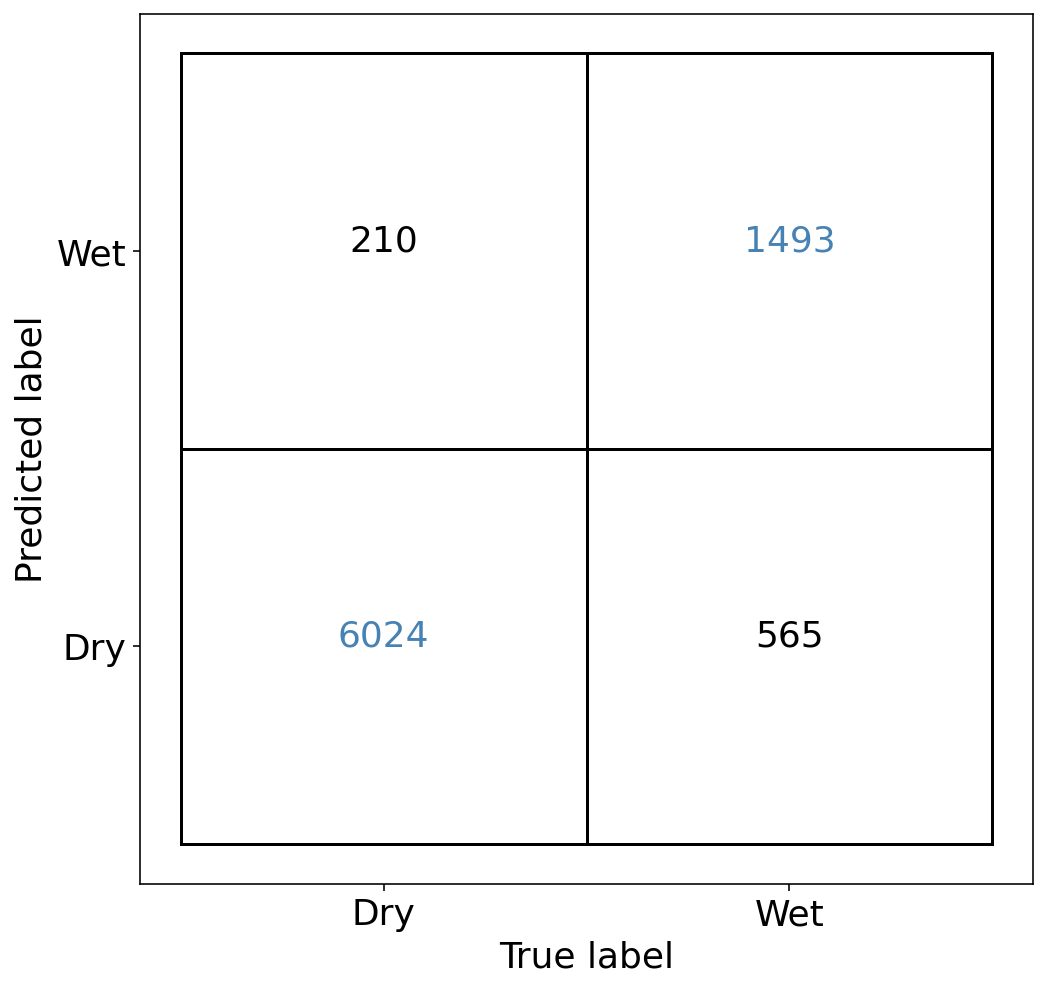

In [534]:
# confusion matrix on test data

from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

plt.rcParams.update({'font.size': 18})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)
f,ax = plt.subplots(1, figsize = (8,8))
# ax.imshow([[1,0],[0,1]],cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['steelblue','k','k','steelblue',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k')
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')

plt.savefig('correlation_matrix.pdf',format='pdf')

###  Explore accuracy of leave-one-date-out train-test splits


In [43]:
subset = df
dates = set(subset.date)
subset['date'] = pd.to_datetime(subset.date)
dates = ['2015-06-04',
 '2015-08-22',
 '2018-02-12',
 '2016-03-07 00:00:00',
 's2wet',
 's1dry',
 's1wet',
 's2dry',
 'highflow']

date_accuracy = {}

for date in dates:
  print(date)
  mask_test1 = ''
  sub1 = subset.set_index('date').sort_index().reset_index()
  numscenes = 0

  if date=='s2wet':
      mask_test = ((sub1.date.between('6-5-2015','8-21-2015')) & (sub1.wet==1))
      mask_test1 = (mask_test) & (sub1.date!='8-22-2015')
  elif date=='s1dry':
      mask_test = ((sub1.date.between('6-5-2015','8-21-2015')) & (sub1.wet==0))
      mask_test1 = (mask_test) & (sub1.date!='6-4-2015')
  elif date=='s1wet':
      mask_test = (sub1.date.between('3-15-2015','5-2-2015'))
      mask_test1 = (mask_test) & (sub1.date!='6-4-2015')
  elif date=='s2dry':
      mask_test = (~(sub1.date.dt.year.isin([2015,2018])) & (sub1.date.dt.month.isin([7,8,9,10])))
      mask_test1 = (mask_test) & (sub1.date!='8-22-2015')
  elif date=='highflow':
      mask_test = ((sub1.date.dt.month.isin([11,12,1,2,3,4,5])) & (sub1.date!='3-7-2016'))
      mask_test1 = mask_test
  elif date=='2015-06-04':
    mask_test = (sub1.date==date)
    mask_test = (mask_test) | (sub1.date.between('3-15-2015','5-2-2015')) # extrapolation of wet reaches from survey 1
    mask_test = (mask_test) | ((sub1.date.between('6-4-2015','8-22-2015')) & (sub1.wet==0)) # extrapolation of dry reaches from survey 1
    mask_test = (mask_test) | ((sub1.date.dt.month.isin([11,12,1,2,3,4,5])) & (sub1.date!='3-7-2016')) # high flow extrapolation
    mask_test1 = (sub1['date']==date)
  elif date=='2015-08-22':
    mask_test = (sub1.date==date)
    mask_test = (mask_test) | ((sub1.date.sort_values().between('6-4-2015','8-22-2015')) & (sub1.wet==1)) # extrapolation of wet reaches from survey 2
    mask_test = (mask_test) | (~(sub1.date.dt.year.isin([2015,2018])) & (sub1.date.dt.month.isin([7,8,9,10]))) # extrapolation of dry reaches from survey 2
    mask_test1 = (sub1['date']==date)
  elif len(mask_test1)==0:
    mask_test = (sub1['date']==date)
    mask_test1 = mask_test

  Xtrain_date = sub1[~mask_test][features]
  Xtest_date = sub1[mask_test1][features]
  # print(len(Xtest_date))

  ytrain_date = sub1[~mask_test]['wet']
  ytest_date = sub1[mask_test1]['wet']
  date_model = RandomForestClassifier(random_state=42)
  date_model.fit(Xtrain_date, ytrain_date)
  try:
    date_accuracy.update({date: date_model.score(Xtest_date, ytest_date)})
  except:
    print(date)

2015-06-04
2015-06-04
2015-08-22
2015-08-22
2018-02-12
2018-02-12
2016-03-07 00:00:00
2016-03-07 00:00:00
s2wet
s2wet
s1dry
s1dry
s1wet
s1wet
s2dry
highflow


In [44]:
date_accuracy.update({'75% of all data as train, 25% as test':test_model.score(Xtest, ytest)})
date_accuracy

{'s2dry': 0.8527662439681293,
 'highflow': 0.5414555037502534,
 '75% of all data as train, 25% as test': 0.9081301789359914}

Text(0.5, 1.0, 'highflow')

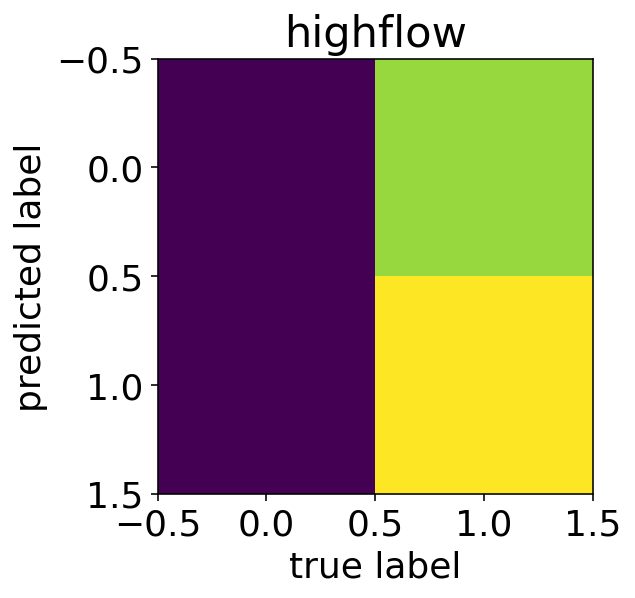

In [47]:

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest_date, date_model.predict(Xtest_date))
plt.imshow(mat.T)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title(date)

##Compare pdfs of test and train data

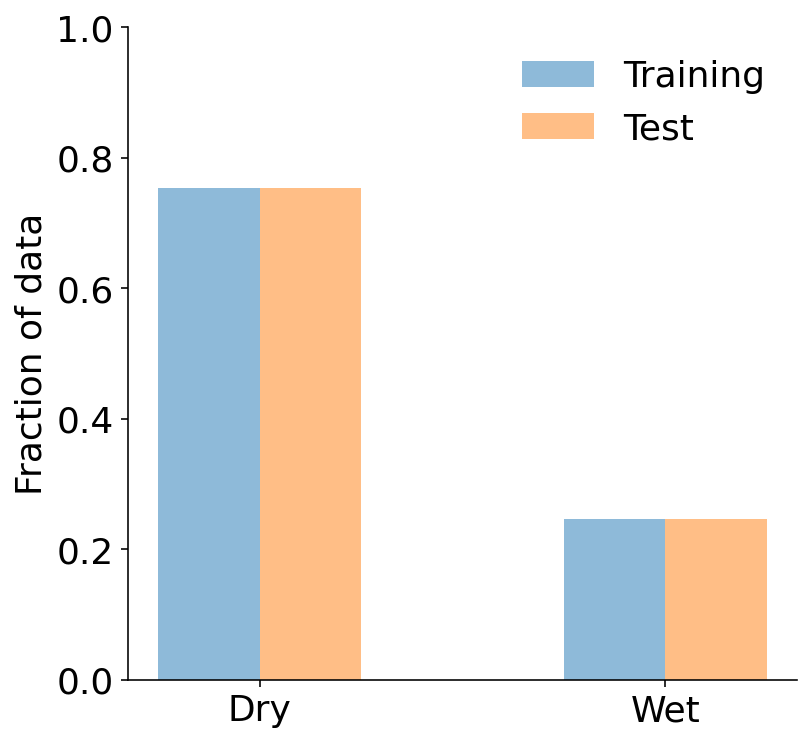

In [48]:
# pdfs of flow presence in training vs test data sets

fig, ax = plt.subplots(figsize = (6,6))

traindata = [len(ytrain[ytrain==0])/len(ytrain),
              len(ytrain[ytrain==1])/len(ytrain)]
testdata = [len(ytest[ytest==0])/len(ytest),
              len(ytest[ytest==1])/len(ytest)]

ax.bar([-.125,1-.125],traindata,
       label = 'Training',alpha=0.5,
       width = 0.25)
ax.bar([.125,1.125],testdata,
       label = 'Test',alpha=0.5,
       width = 0.25)
ax.legend(frameon=False)
ax.set_xticks([0,1])
ax.set_xticklabels(['Dry','Wet'])

ax.set_ylim(0,1)
ax.set_ylabel('Fraction of data')

ax.spines[['right', 'top']].set_visible(False)

plt.savefig('train_test_compare.png',format='png',bbox_inches='tight')

# check intra-sample prediction uncertainty

In [49]:
n_est=100
pred_list = np.empty([len(Xtest),n_est])
for i in np.arange(n_est):
  pred_list[:,i]=(model.estimators_[i].predict(Xtest))


/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/danalapides/opt/minicon

(array([2752., 1140.,  730., 1019.,  606.,  576.,  492.,  283.,  339.,
         390.]),
 array([0.        , 0.04999   , 0.09998   , 0.14997   , 0.19996   ,
        0.24994999, 0.29993999, 0.34992999, 0.39991999, 0.44990999,
        0.49989999]),
 <BarContainer object of 10 artists>)

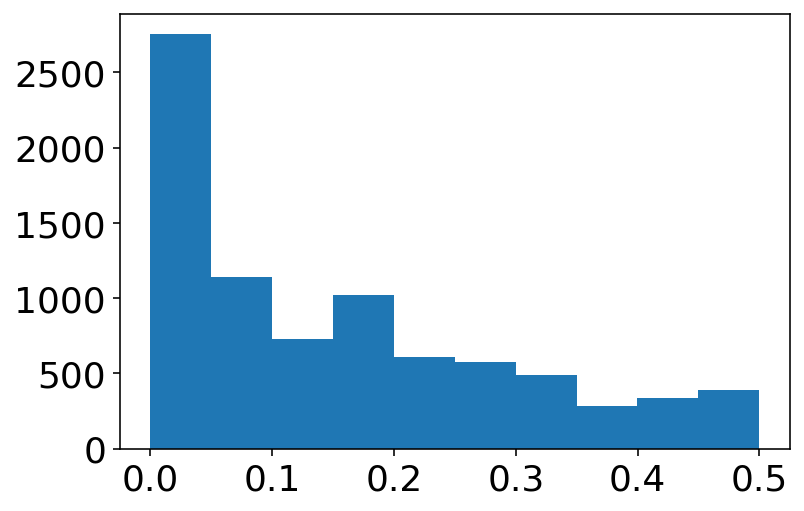

In [50]:
plt.hist(pred_list.std(axis=1))

# Plot decision tree

In [51]:
estimator = model.estimators_[42]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', max_depth=3,
                feature_names = features,
                class_names = ['dry','wet'], # THESE MIGHT BE MIXED UP
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

# Permutation importance

In [394]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, X, Y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)



/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core

Elapsed time to compute the importances: 11.088 seconds


6178 0.5 0.5
201 1.5 0.5
56 0.5 1.5
1857 1.5 1.5


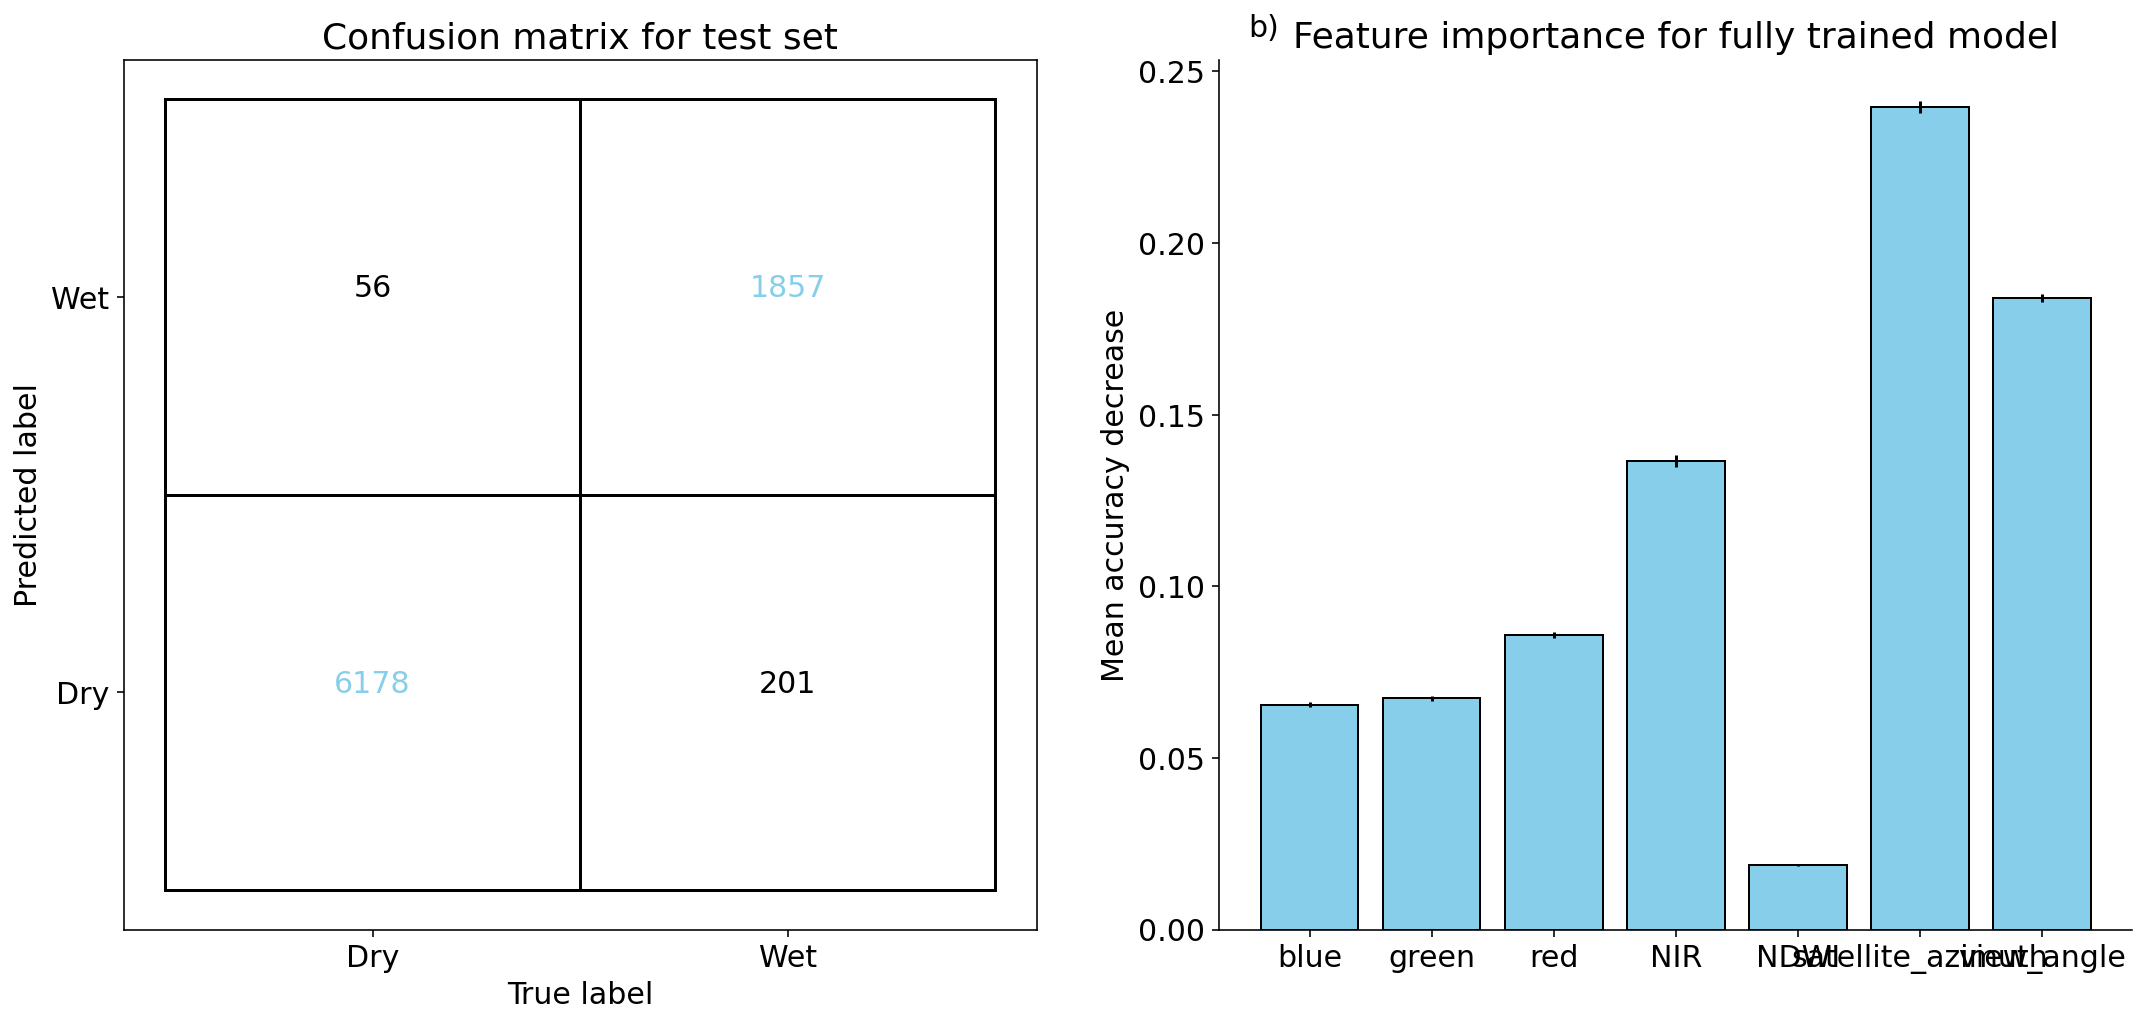

In [395]:
# confusion matrix with feature importance

# Manuscript figure; confusion matrix on test data

plt.rcParams.update({'font.size': 15})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)


f,axs = plt.subplots(1, 2, figsize = (18,8))

ax = axs[0]
# sns.heatmap([[1,0],[0,1]], square=True, annot=False,fmt='d',
#             cbar=False,ax=ax, cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['skyblue','k','k','skyblue',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k',clip_on=False)
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_title('Confusion matrix for test set')
ax.text(.05,0.11,'a)',c='white')

ax = axs[1]

labels = features#['Blue','Green','Red','NIR','NDWI',]#'Area']
ax.bar(labels,forest_importances.values,
       yerr = result.importances_std,
       edgecolor = 'k',facecolor = 'skyblue')
ax.set_title("Feature importance for fully trained model")
ax.set_ylabel("Mean accuracy decrease")
ax.text(-.5,0.26,'b)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# fig.tight_layout()


plt.savefig('confusion_and_importance.pdf',format='pdf',bbox_inches='tight')

In [396]:
features

['blue', 'green', 'red', 'NIR', 'NDWI', 'satellite_azimuth', 'view_angle']

In [58]:
forest_importances#.values, labels, result.importances_std

blue     0.117751
green    0.136469
red      0.147783
NIR      0.253614
NDWI     0.076160
dtype: float64

## rank correlation hierarchy

In [60]:
# import scipy
# from scipy.cluster import hierarchy as hc

# corr = np.round(scipy.stats.spearmanr(subset).correlation, 4)
# corr_condensed = hc.distance.squareform(1-corr)
# z = hc.linkage(corr_condensed, method='average')
# fig = plt.figure(figsize=(16,10))
# dendrogram = hc.dendrogram(z, labels=subset.columns,
#       orientation='left', leaf_font_size=16)
# plt.show()

# make some maps

In [535]:
len(df),len(X)

(33165, 33165)

In [536]:
ypred_all = test_model.predict(X)
df['prediction'] = ypred_all

In [537]:
df[df.assumption=='survey/imagery match'].date.unique()

array([datetime.date(2022, 6, 13), datetime.date(2018, 6, 23),
       datetime.date(2020, 6, 15), datetime.date(2019, 6, 15),
       datetime.date(2023, 6, 13), datetime.date(2021, 6, 16)],
      dtype=object)

Text(-110.325, 31.455000000000002, 'Comparison')

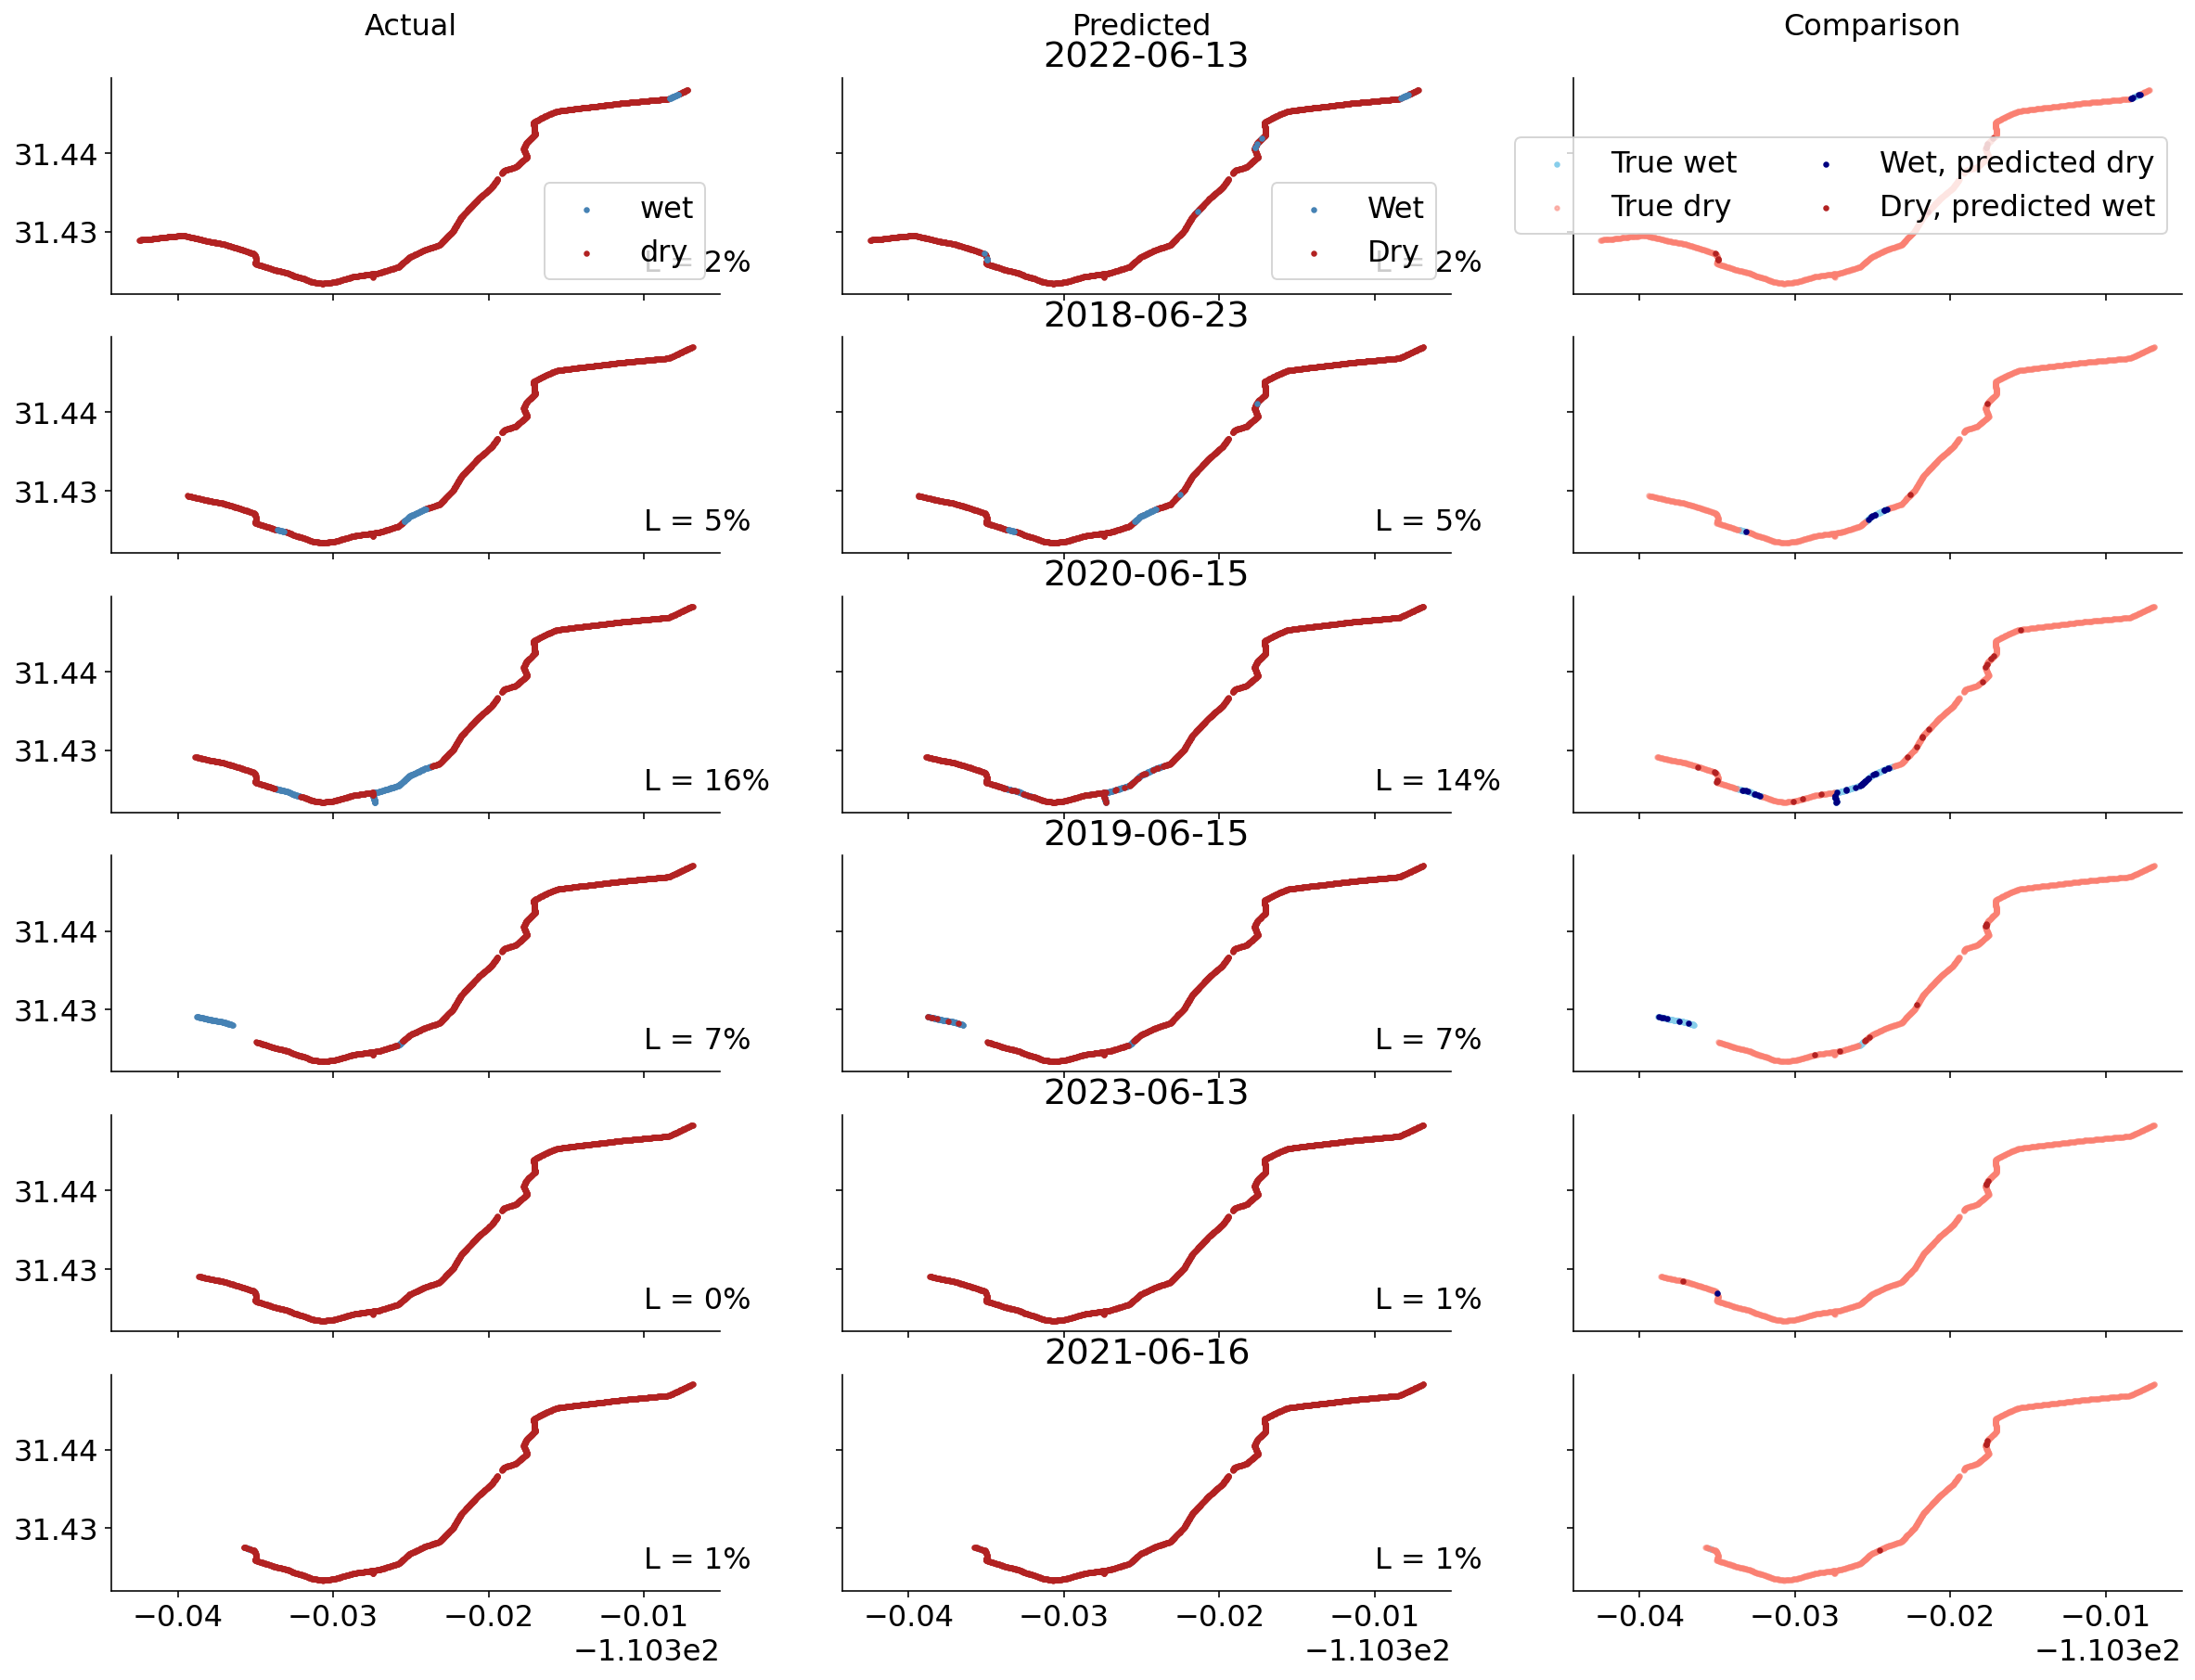

In [538]:
import matplotlib as mpl
import geopandas as gpd

size = 5

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(6,3,figsize = (20,15),
                       sharex=True,
                       sharey=True)
subset = df

xv,yv = -110.31,31.425

i=0
for date in df[df.assumption=='survey/imagery match'].date.unique():#subset.date.drop_duplicates().values[:4]:
  dfsub = subset[subset.date==date]
  if date=='2018-02-12':
    dfsub = dfsub[dfsub.area_updated<=20000]
  dfsub = dfsub.drop_duplicates()
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

  ax = axs[i,0]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

    # ax.set_title('Actual')

  ax = axs[i,1]

  dfsub1 = dfsub[(dfsub.prediction==1)]
  pwet = len(dfsub1)/len(dfsub)*100
  ax.scatter(dfsub1.x,dfsub1.y,c='steelblue',
             s=size,label='Wet',
             zorder = zorder)
  dfsub1 = dfsub[(dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,c='firebrick',
             s=size,label='Dry',zorder = zord1)
  ax.set_title(str(date)[:10])
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax = axs[i,2]

  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='skyblue',label='True wet',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='salmon',label='True dry',
             s=size, alpha=0.5)
  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='navy',label='Wet, predicted dry',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='firebrick',label='Dry, predicted wet',
             s=size)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if i==0:
    legend = ax.legend(ncol=2)
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]
#     legend.legendHandles[2]._sizes = [size1]
#     legend.legendHandles[3]._sizes = [size1]
  n = 70

  i+=1



axs[0,0].text(xv-.015,yv+.03,'Actual',
              ha = 'center',fontsize = 16)
axs[0,1].text(xv-.015,yv+.03,'Predicted',
              ha = 'center',fontsize = 16)
axs[0,2].text(xv-.015,yv+.03,'Comparison',
              ha = 'center',fontsize = 16)

# labels = ['a)','b)','c)',
#           'd)','e)','f)',
#           'g)','h)','i)',
#           'j)','k)','l)']

# k=0
# for i in range(4):
#   for j in range(3):
#     axs[i,j].text(-123.517,39.579,labels[k],
#                   fontsize = 16)
#     # print(i,j,k)
#     k+=1

# ax = axs[3,0]
# labels = [item.get_text() for item in ax.get_xticklabels()]
# for ax in [axs[3,0],axs[3,1],axs[3,2]]:
#   ax.set_xticklabels(labels,rotation=90)
#   ax.set_xlabel('Longitude')

# for ax in [axs[0,0],axs[1,0],axs[2,0]]:
#   ax.set_ylabel('Latitude')

# plt.savefig('training_maps.pdf',format='pdf',bbox_inches='tight')

x             y        date wetdry         assumption  \
3444   563350.77752  3.476892e+06  2017-08-26    wet  assumed perennial   
3445   563350.77752  3.476892e+06  2017-08-29    wet  assumed perennial   
3446   563350.77752  3.476892e+06  2017-08-30    wet  assumed perennial   
3798   563350.77752  3.476892e+06  2020-03-09    wet  assumed perennial   
3799   563350.77752  3.476892e+06  2020-03-19    wet  assumed perennial   
...             ...           ...         ...    ...                ...   
11171  563377.25792  3.476878e+06  2023-03-13    wet  assumed perennial   
11172  563377.25792  3.476878e+06  2023-03-23    wet  assumed perennial   
11173  563377.25792  3.476878e+06  2023-03-25    wet  assumed perennial   
11174  563377.25792  3.476878e+06  2023-03-26    wet  assumed perennial   
11175  563377.25792  3.476878e+06  2023-03-28    wet  assumed perennial   

           blue     green       red       NIR  missing  ...  sun_azimuth  \
3444   0.089148  0.322624  0.310439  0.856742        0  ...        119.6   
3445   0.353390  0.395626  0.362550  0.786991        0  ...        146.0   
3446   0.056218  0.209076  0.246880  0.647069        0  ...        123.1   
3798   0.007002  0.239344  0.269294  0.587779        0  ...        135.7   
3799   0.712658  0.728300  0.596383  0.738959        0  ...        136.3   
...         ...       ...       ...       ...      ...  ...          ...   
11171  0.204429  0.426332  0.326772  0.675309        0  ...        129.2   
11172  0.445775  0.487296  0.387529  0.735169        0  ...        135.2   
11173  0.439148  0.497903  0.396016  0.744152        0  ...        130.2   
11174  0.390681  0.513807  0.383602  0.741423        0  ...        123.9   
11175  0.335230  0.444553  0.366073  0.686568        0  ...        139.6   

       sun_elevation  view_angle  doy  time  wet  prediction  Unnamed: 0  \
3444            54.2         4.0  238    17    1           1  2017-08-26   
3445            64.1         0.1  241    18    1           1  2017-08-29   
3446            54.3         1.0  242    17    1           1  2017-08-30   
3798            44.4         5.0   69    17    1           1  2020-03-09   
3799            49.7         1.0   79    17    1           0  2020-03-19   
...              ...         ...  ...   ...  ...         ...         ...   
11171           42.1         2.7   72    17    1           1  2023-03-13   
11172           50.6         4.9   82    17    1           1  2023-03-23   
11173           49.2         4.9   84    17    1           1  2023-03-25   
11174           45.7         4.9   85    17    1           1  2023-03-26   
11175           54.9         1.2   87    17    1           1  2023-03-28   

       Q [mm/d]  P [mm]  
3444   0.007379     0.0  
3445   0.005975     0.0  
3446   0.005614     0.0  
3798   0.006356     0.0  
3799   0.007499     0.0  
...         ...     ...  
11171  0.010447     0.0  
11172  0.007198     0.0  
11173  0.006376     0.0  
11174  0.005995     0.0  
11175  0.005233     0.0  

[196 rows x 33 columns]

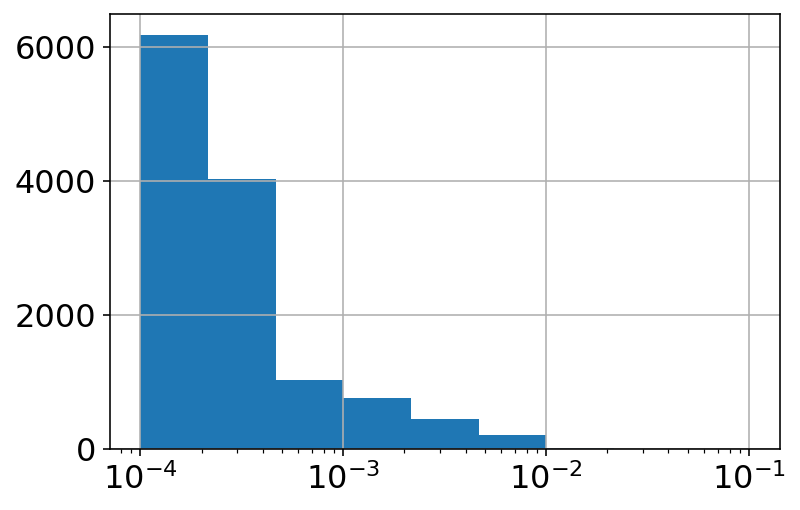

In [539]:
hydro = hydro.reset_index()
hydro['date'] = hydro['Unnamed: 0'].dt.date
hydro = hydro.set_index('date')
combo = df.merge(hydro,left_on='date',right_index=True)
combo['Q [mm/d]'].hist(bins=np.logspace(-4,-1,10))
plt.xscale('log')
combo[(combo['Q [mm/d]']>5e-3)]#&(combo['Q [mm/d]']<10e-3)]

# Make predictions for all dates with PlanetScope data

In [446]:
# # import data and resave as smaller files for github
# # save this block

# bad_dates = ['2019-12-23','2019-10-20','2019-09-30', # cloudy or snowy dates
#              '2019-02-28','2019-02-22','2018-11-19',
#              '2018-12-10','2016-12-17','2018-10-08',
#              '2018-10-31','2018-09-14','2018-07-27',
#              '2018-04-17','2018-03-29','2018-03-26',
#              '2018-01-30','2017-12-27','2017-12-26',
#              '2017-11-18','2017-09-04','2017-08-11',
#              '2017-07-29','2017-02-27','2017-01-24',
#              '2016-05-25','2016-03-15','2016-02-12',
#              '2016-02-02','2015-12-29','2015-12-26',
#              '2016-03-23','2016-11-10',
#              '2015-08-19','2015-08-16','2015-08-03','2015-07-06',
#              '2015-04-24','2014-09-26','2014-09-22','2014-09-17',
#              '2014-03-10','2013-10-28','2013-08-20','2013-06-18',
#              '2013-03-29','2013-03-25','2013-02-21','2013-02-06',
#              '2013-02-02','2012-12-06','2012-10-28','2012-10-25',
#              '2012-10-19','2012-08-23','2012-04-14','2012-03-06',
#              '2012-02-14','2012-02-06','2012-02-05','2012-01-23',

#              '2011-10-06','2011-09-15','2011-04-05','2011-02-22',
#              '2011-01-10','2010-10-23','2010-11-28','2010-11-03',
#              '2010-09-20','2010-04-19','2010-02-05','2010-01-05',
#              '2009-10-04','2009-09-12'
#              ]

# df_alldates1 = pd.read_csv('/content/drive/MyDrive/Sky_Data/rapideye_predict_data_buffer1.csv')

# df_new = ''
# for date in df_alldates1.date.unique():
#   df1 = df_alldates1[df_alldates1.date==date].drop(columns=[
#       'Lithology_']).drop_duplicates()
#   # print(len(df))
#   if len(df_new)==0:
#     df_new = df1
#   else:
#     df_new = pd.concat([df_new,df1])
# df_alldates1 = df_new

# df_alldates1['datetime'] = df_alldates1['datetime_x']

# df_alldates = df_alldates1[df_alldates1['area_updated'].astype(float)>area_thresh]
# df_alldates = df_alldates.loc[pd.to_datetime(df_alldates['datetime'])>dry_runoff.index.values[0]]
# df_alldates = df_alldates[~(df_alldates.date.isin(bad_dates))]

# l = int(len(df_alldates)/10)
# for i in range(11):
#   df_alldates.iloc[l*i:l*(i+1)+1].to_csv('predict_data_'+str(i)+'.csv',index=False
                                        #  )

In [540]:
# read in data
import glob

df_alldates = glob.glob('../data/'+site+'/processed_imagery/*.csv')
df_alldates = [pd.read_csv(s) for s in df_alldates]
df_alldates = pd.concat(df_alldates)
df_alldates = df_alldates.dropna().drop_duplicates()
df_alldates = df_alldates.groupby(['geometry','date']).first().reset_index()
df_alldates['date'] = pd.to_datetime(df_alldates['date'],format='%Y%m%d')
df_alldates['date'] = df_alldates.date.dt.date
df_alldates = df_alldates.merge(metad,on='date')

In [541]:
X_alldates = df_alldates[features]
X_alldates.replace([np.inf, -np.inf], np.nan, inplace=True)
X_alldates = X_alldates.fillna(X_alldates.median())

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/2470643163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_alldates.replace([np.inf, -np.inf], np.nan, inplace=True)


In [542]:
ypred_alldates = model.predict(X_alldates)
df_alldates['predict'] = ypred_alldates

Text(0.5, 0.98, 'Ramsey')

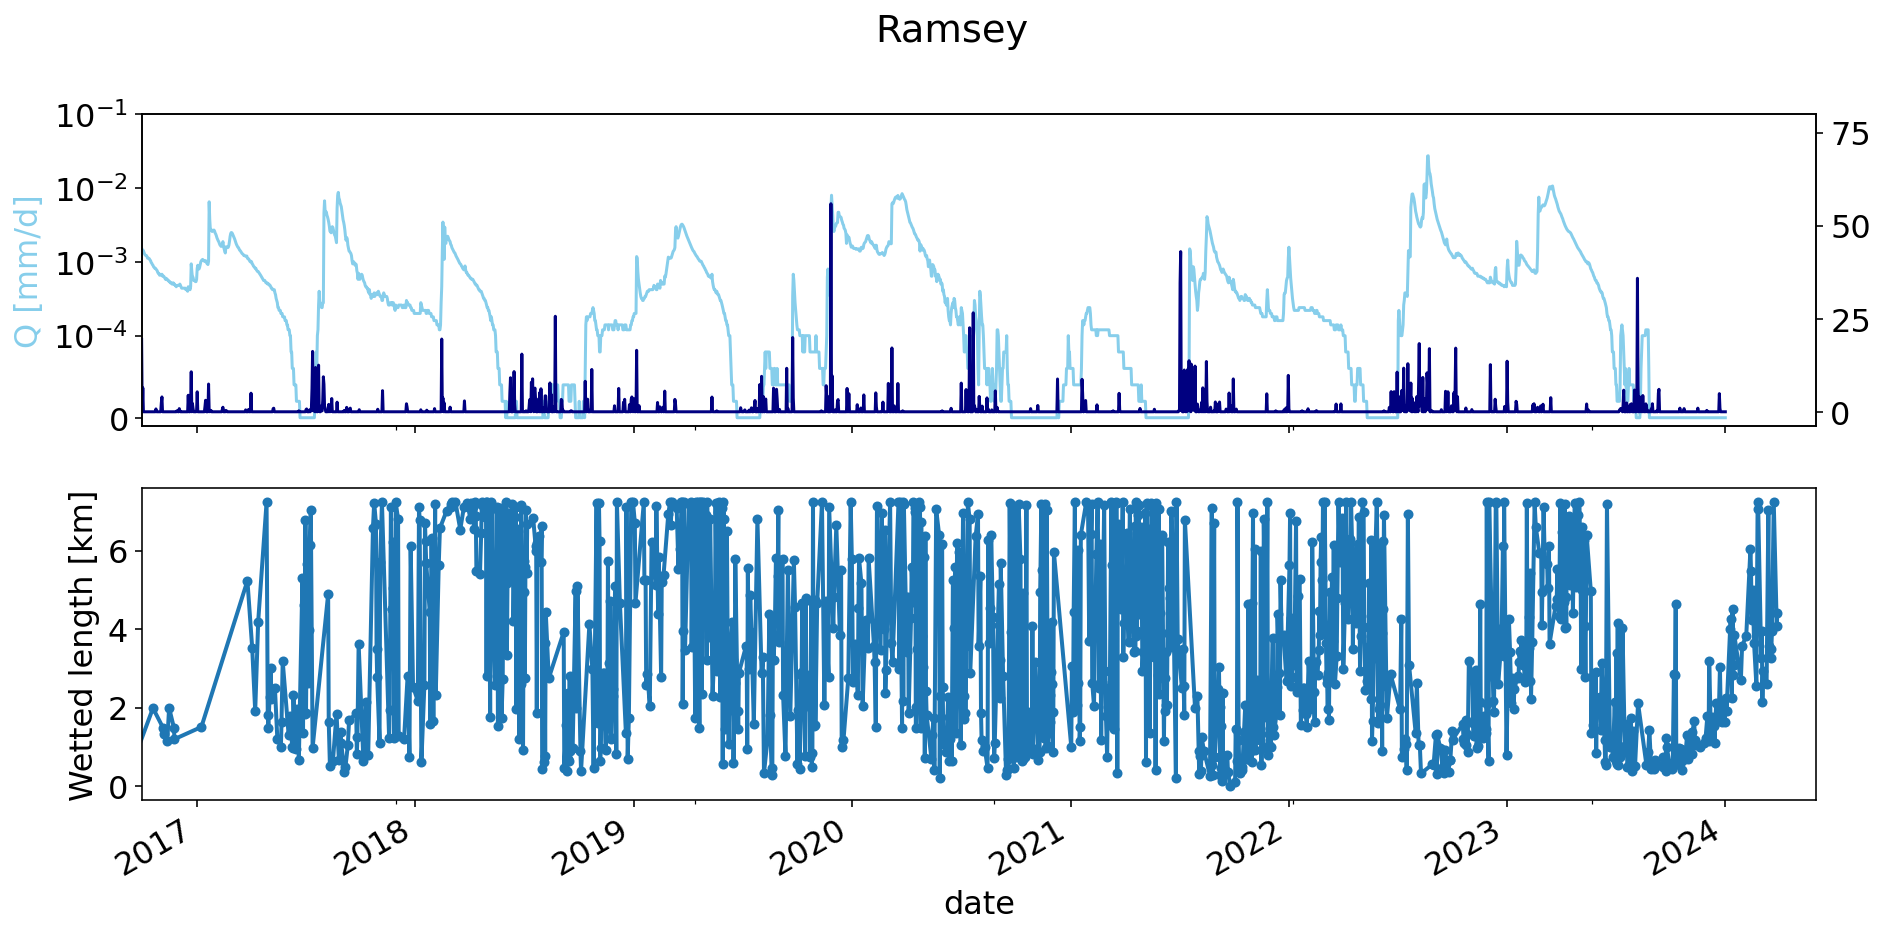

In [543]:
df_alldates['date'] = pd.to_datetime(df_alldates.date,format='%Y%m%d')

fig,axs = plt.subplots(2,figsize = (15,7),sharex=True)
ax = axs[0]
hydro['Q [mm/d]'].plot(ax=ax,c='skyblue')
ax.set_yscale('symlog',linthresh=0.0001)
ax.set_ylim(-.00001,0.1)
ax.set_ylabel('Q [mm/d]',c='skyblue')
axt = ax.twinx()
hydro['P [mm]'].plot(ax=axt,c='navy')
# ax

ax = axs[1]
(df_alldates.groupby('date').predict.sum()*5/1000).plot(ax=ax,lw=2,marker='o',markersize = 4)
ax.set_ylabel('Wetted length [km]')

ax.set_xlim('2016-10-01','2024-6-01')
fig.suptitle(site)

In [546]:
hydro['Unnamed: 0']=pd.to_datetime(hydro['Unnamed: 0'])
hydro.set_index('Unnamed: 0',inplace=True)

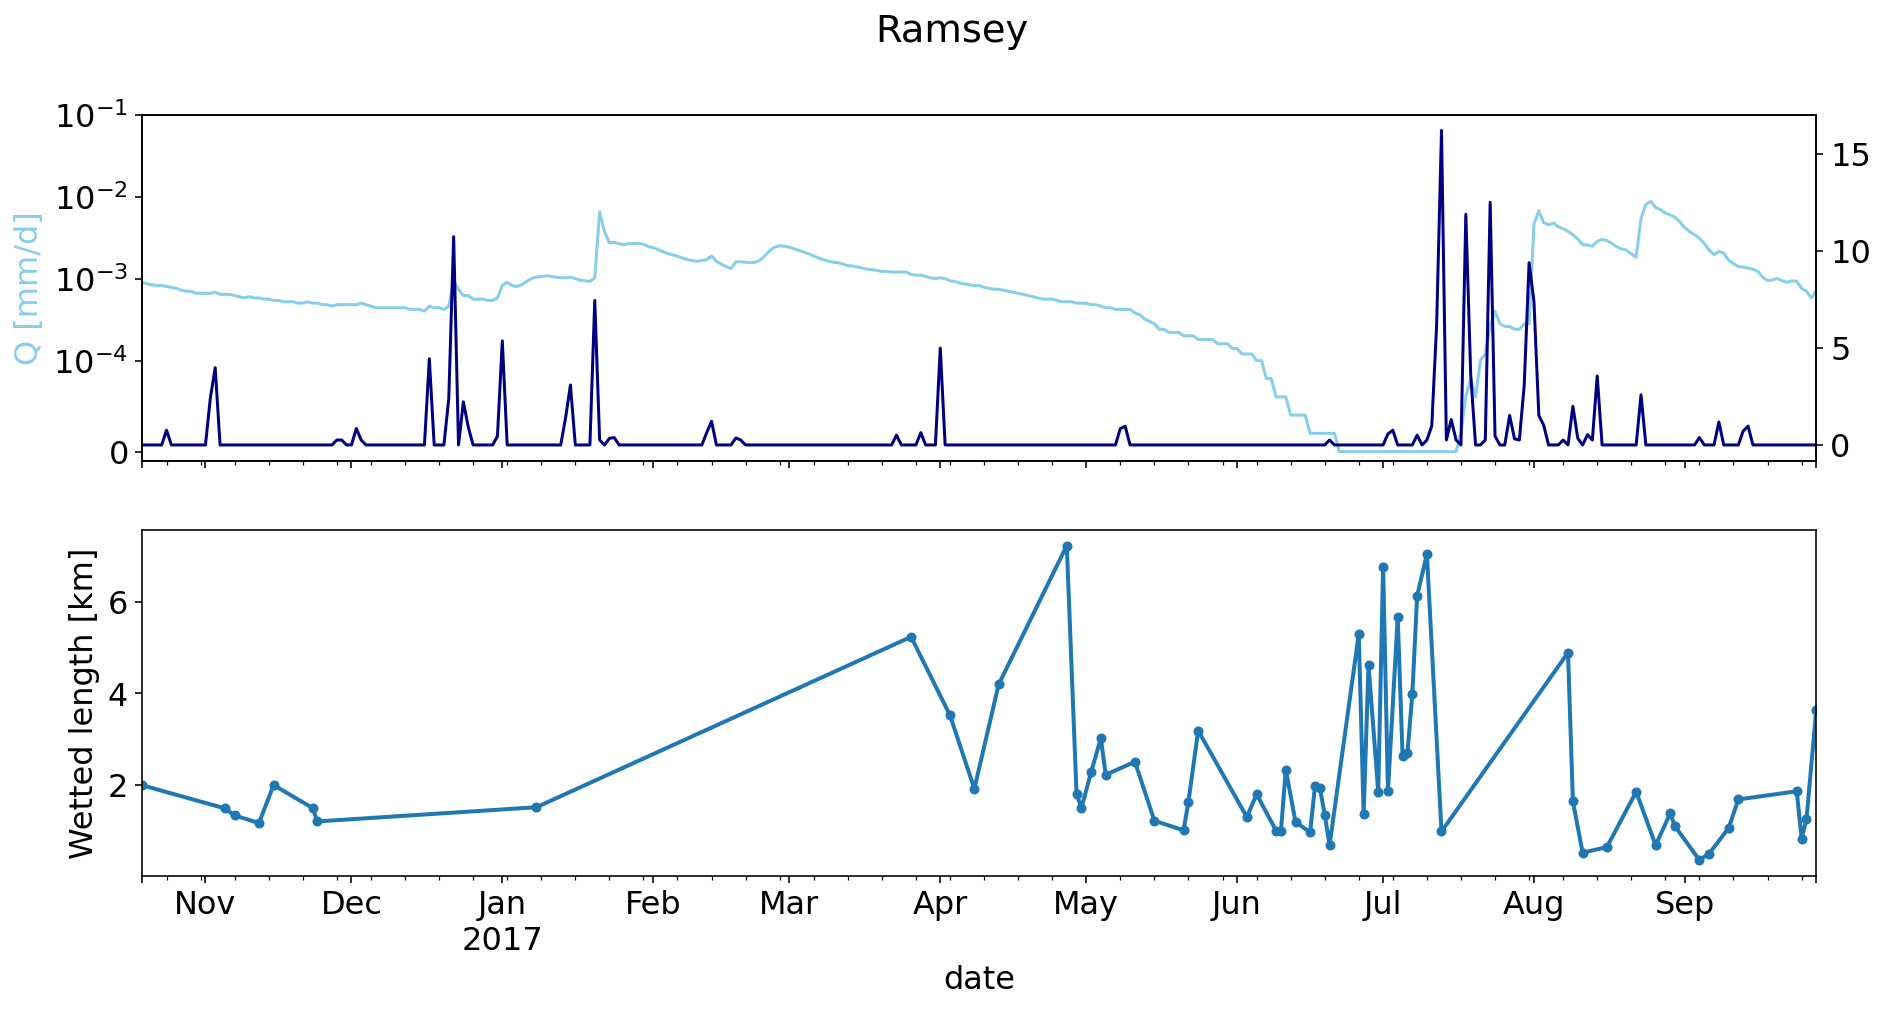

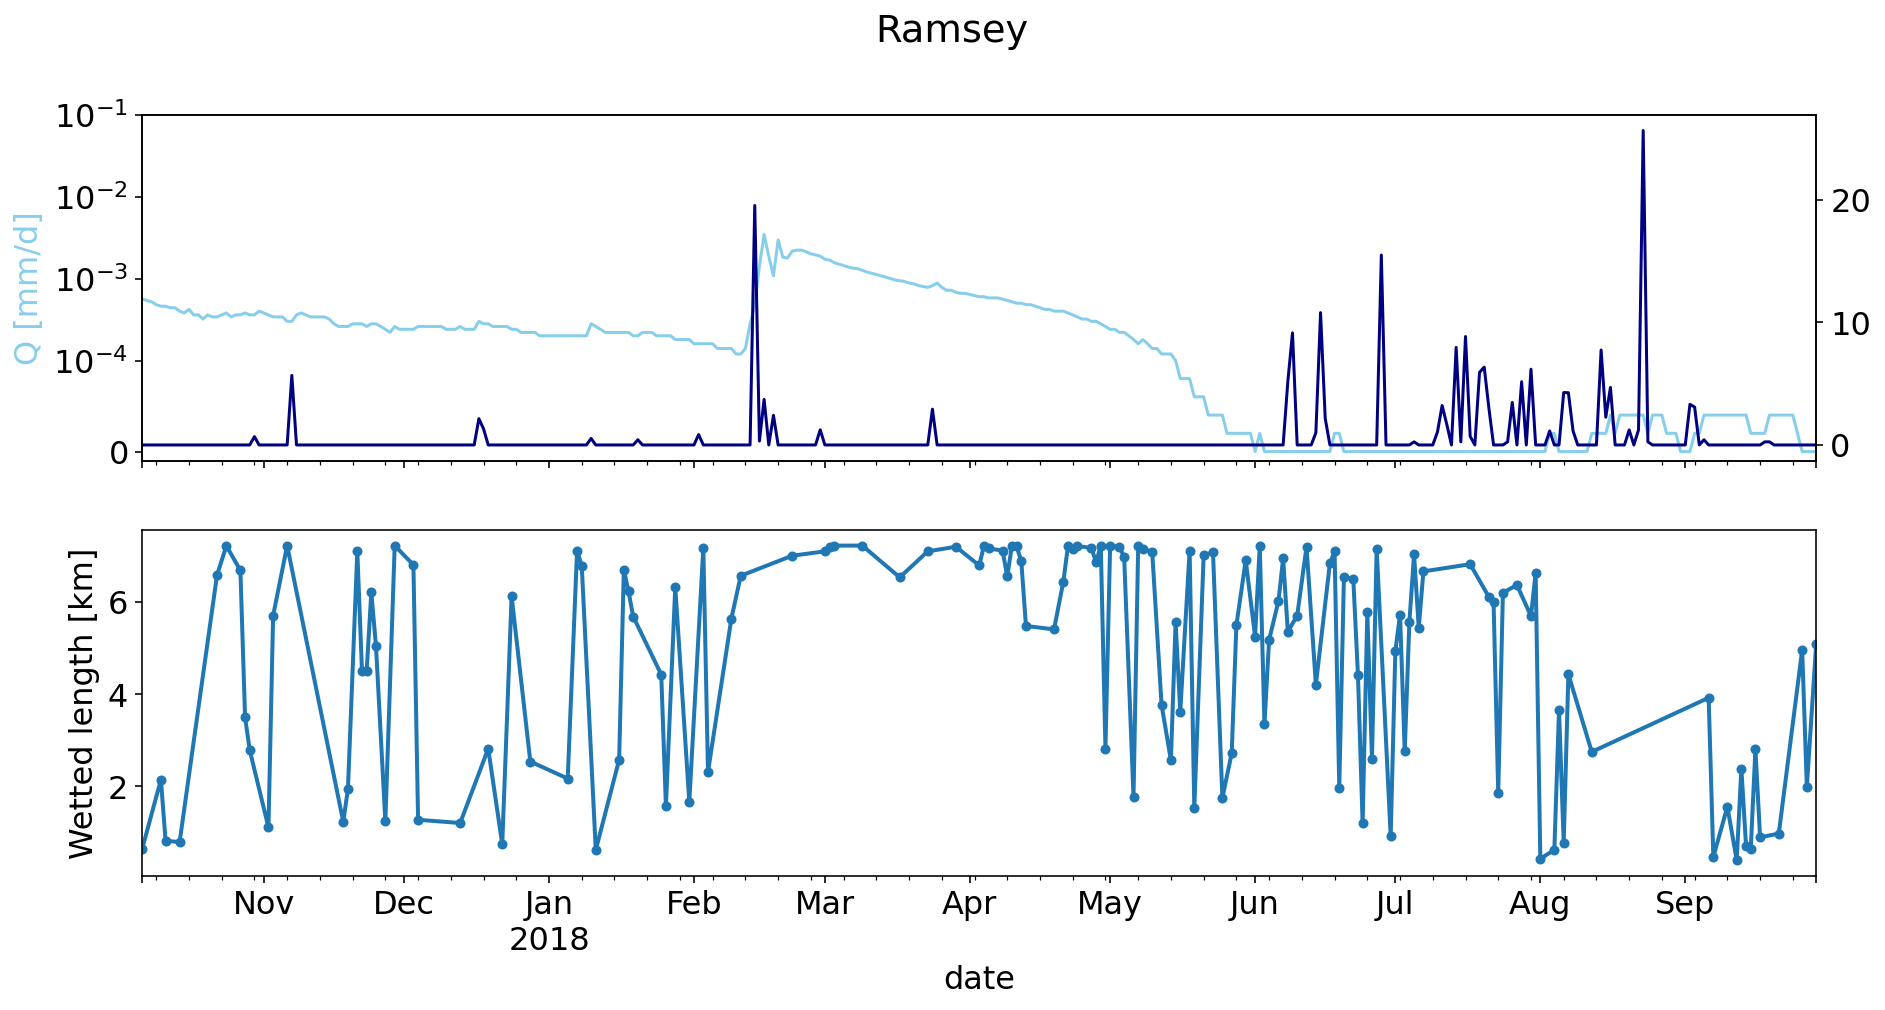

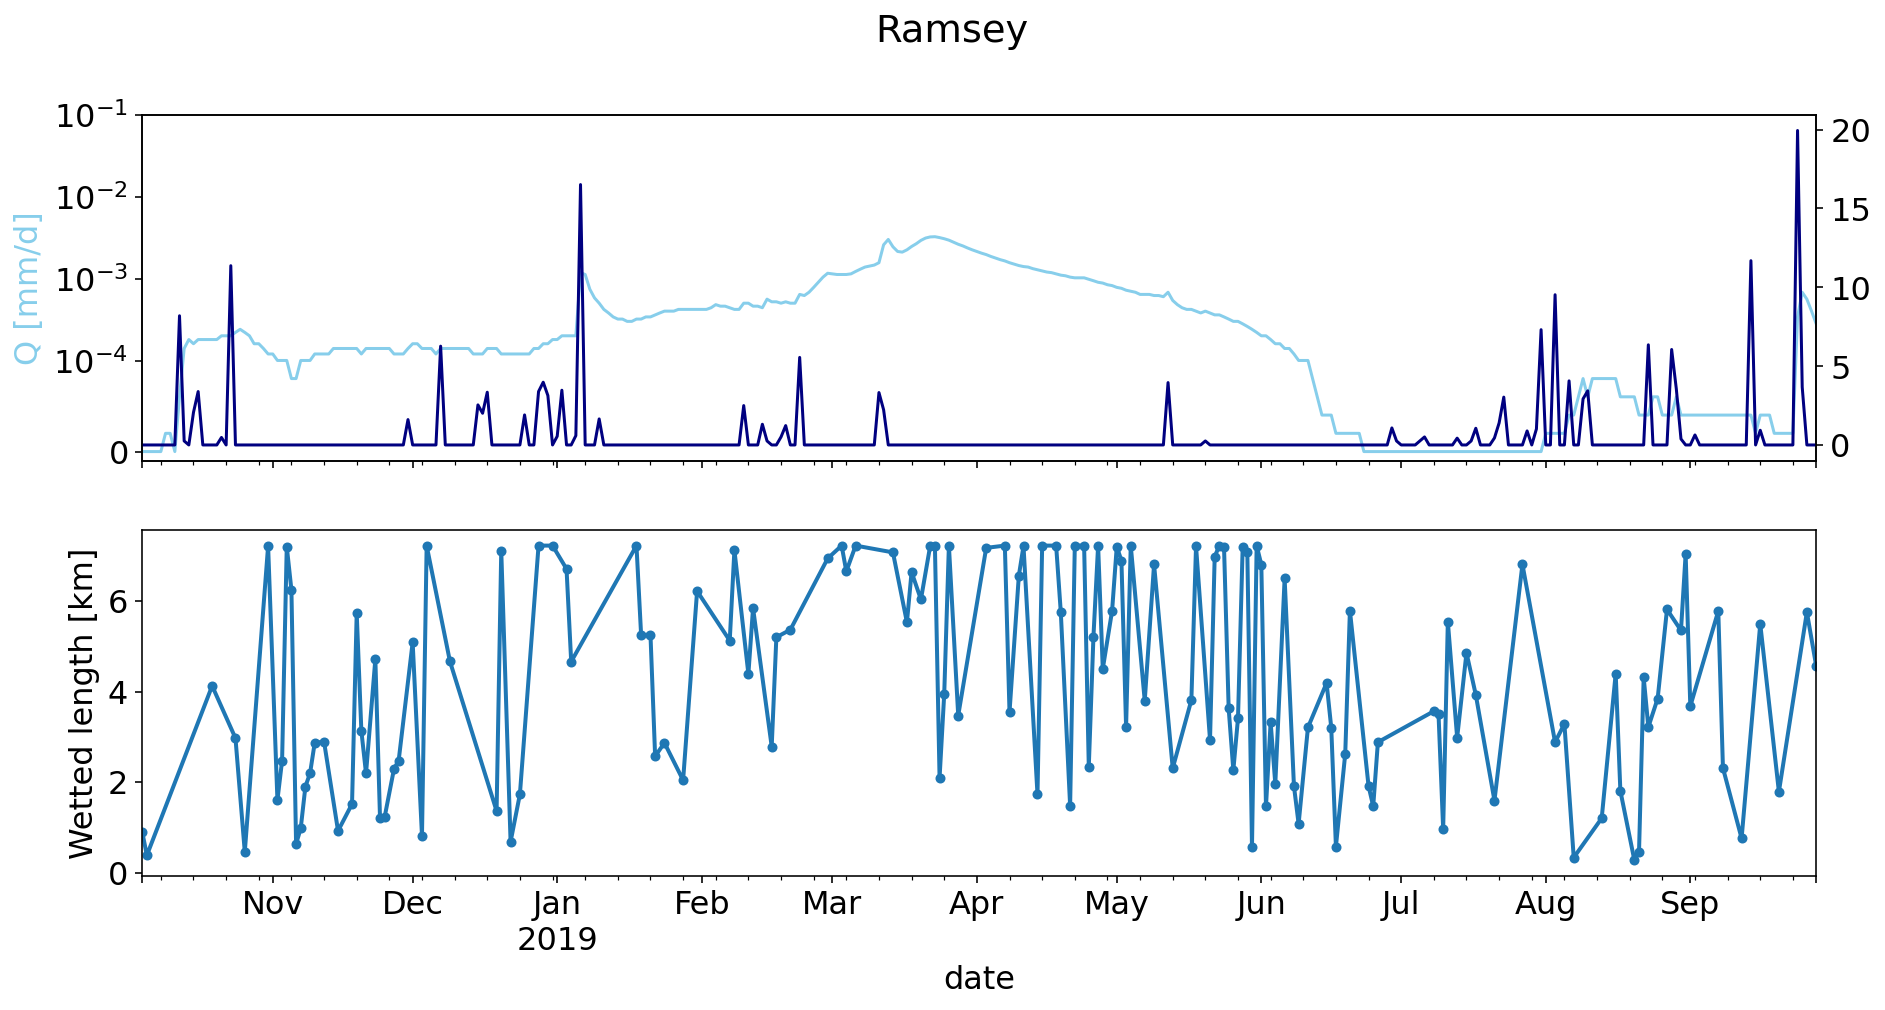

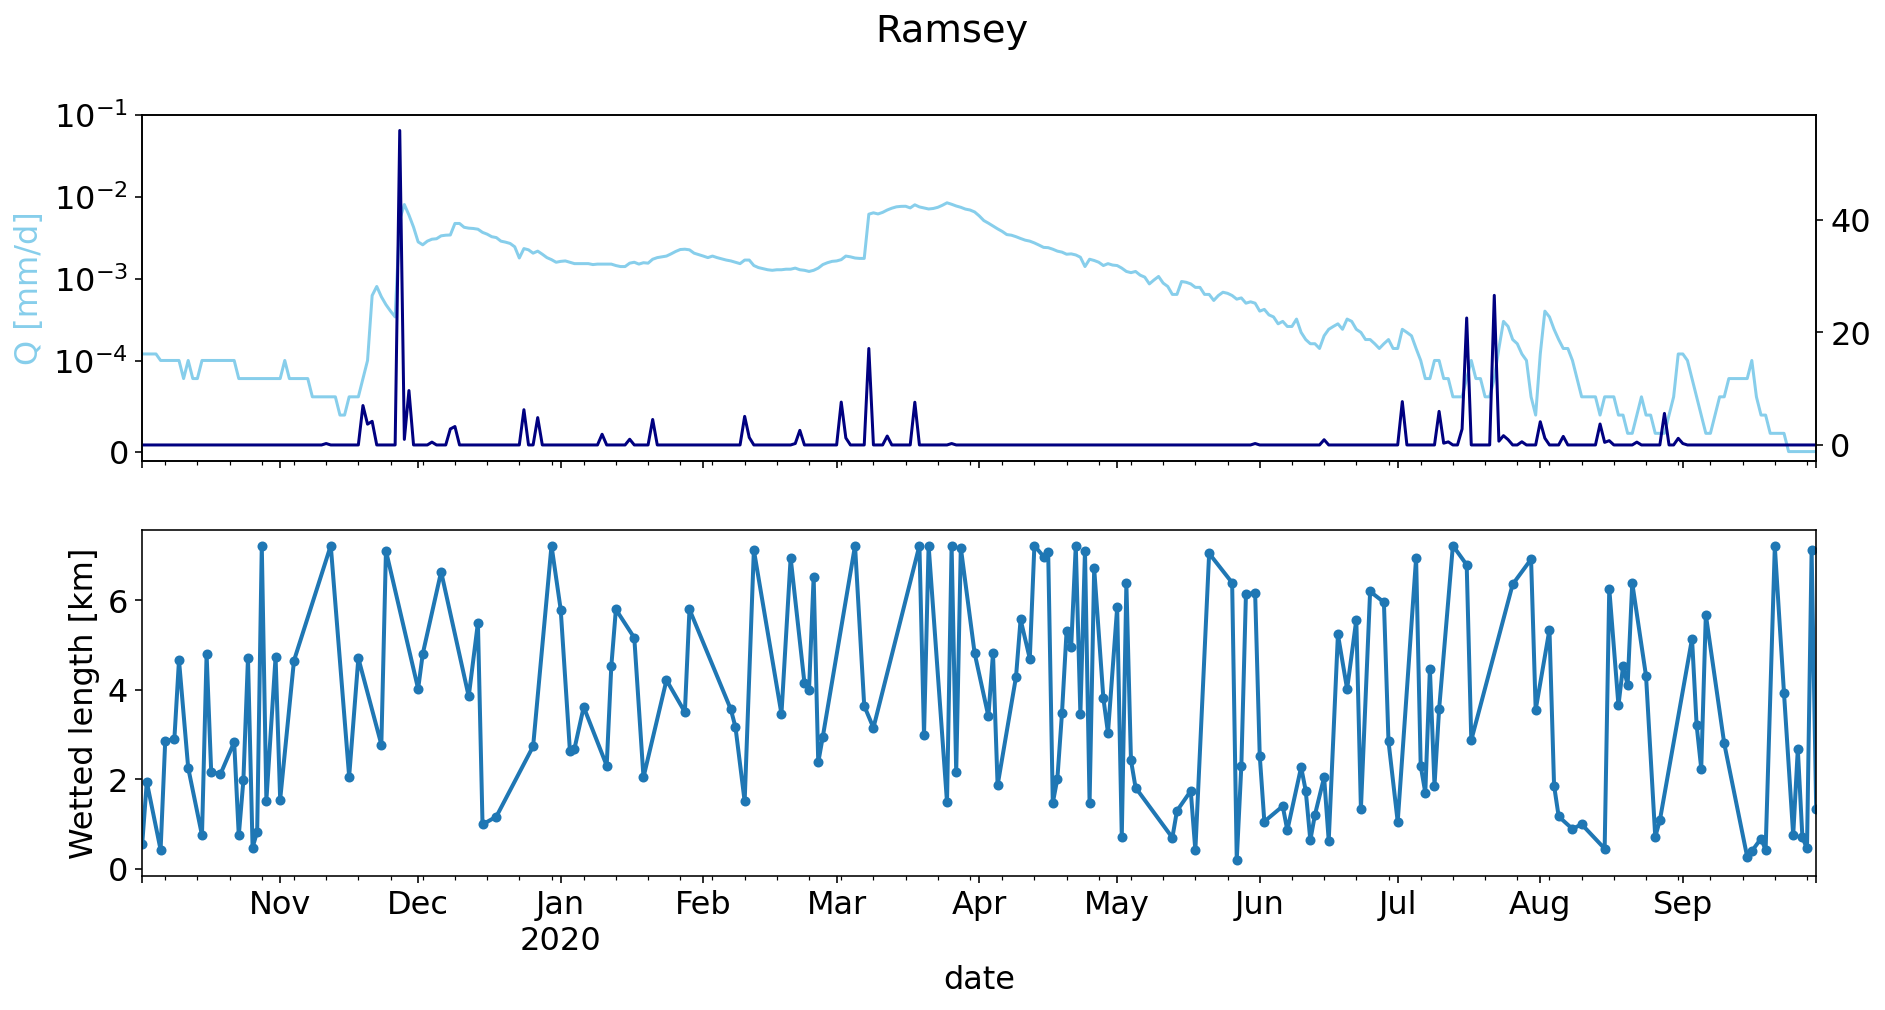

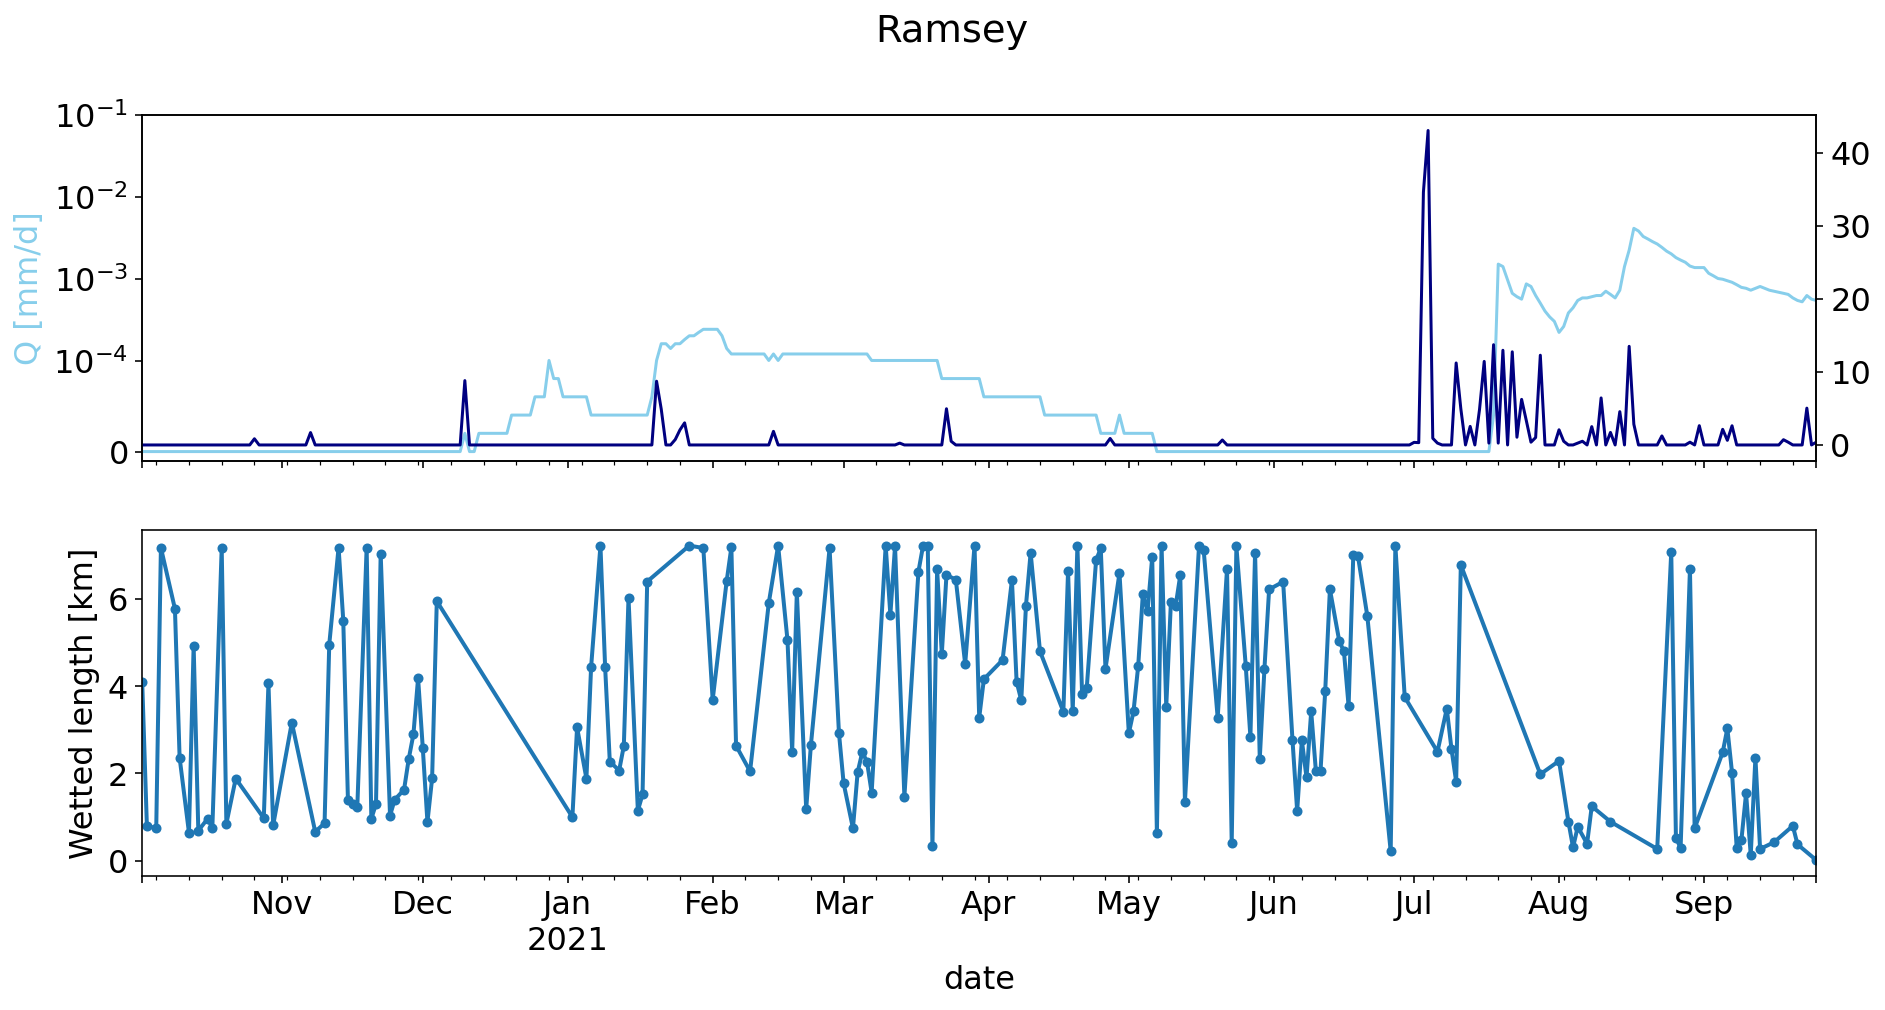

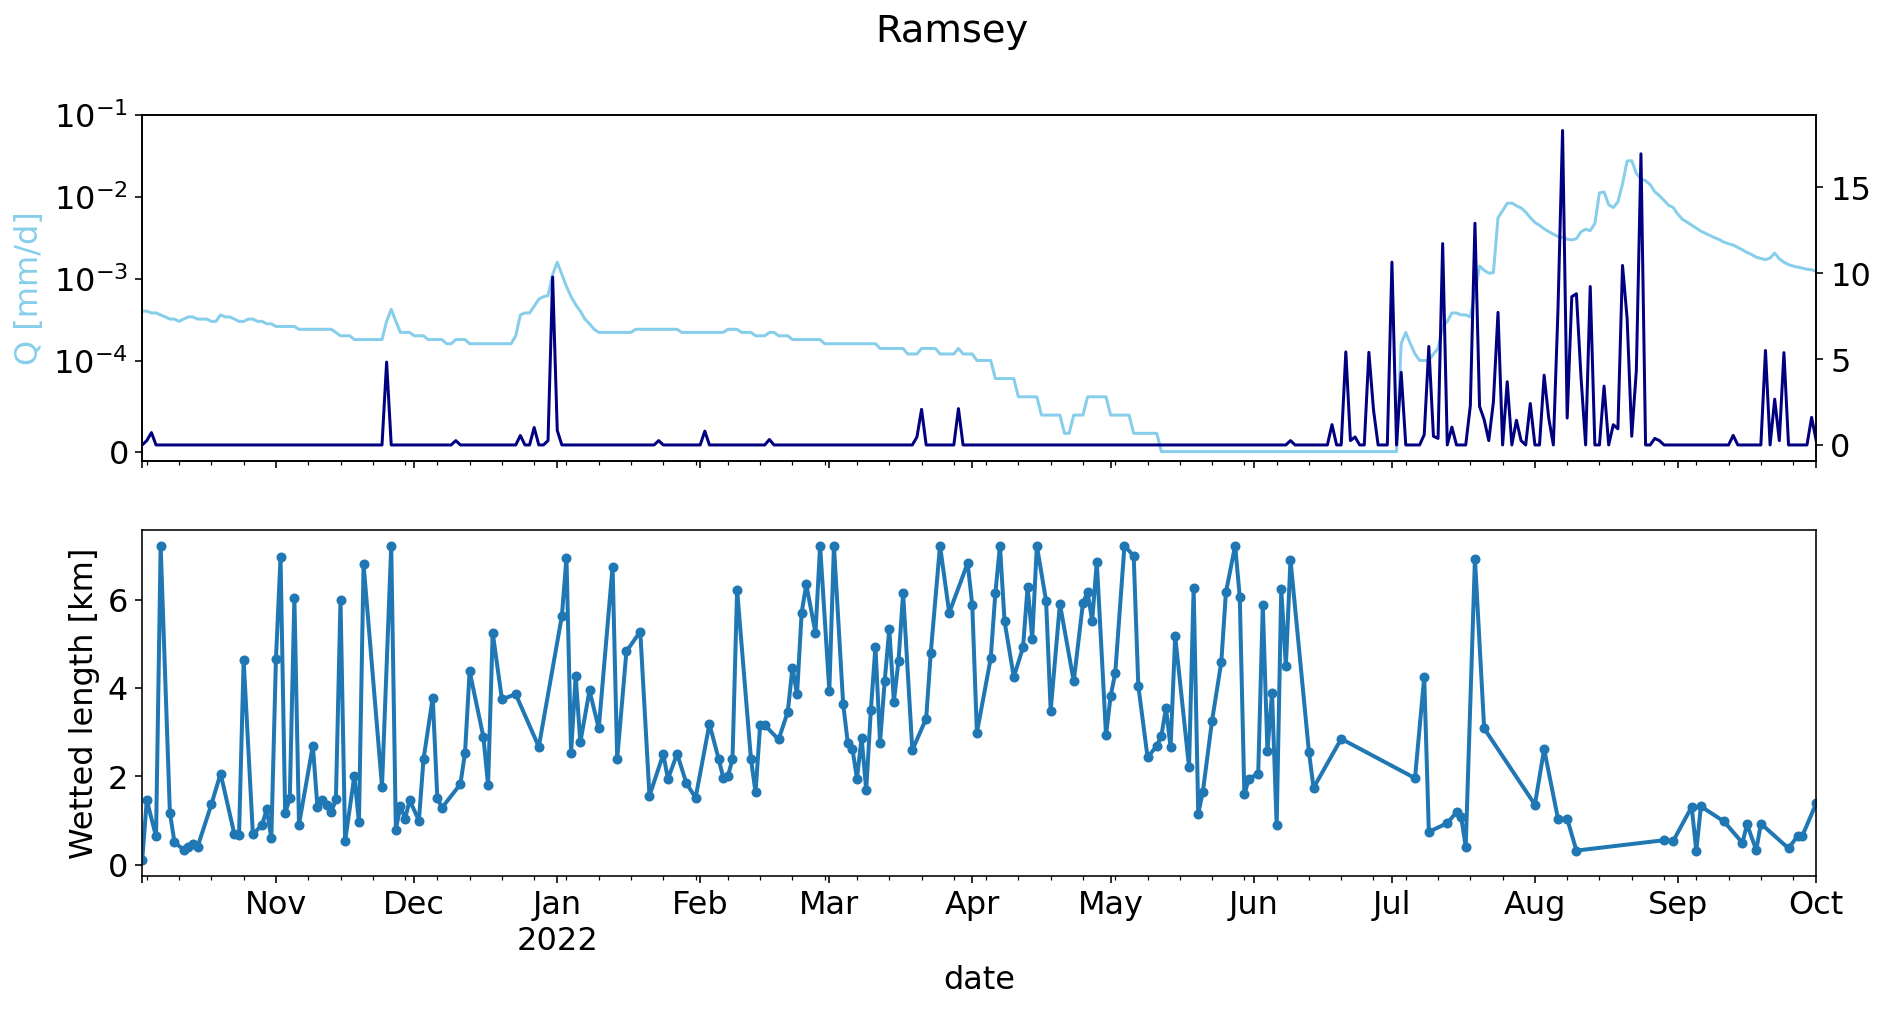

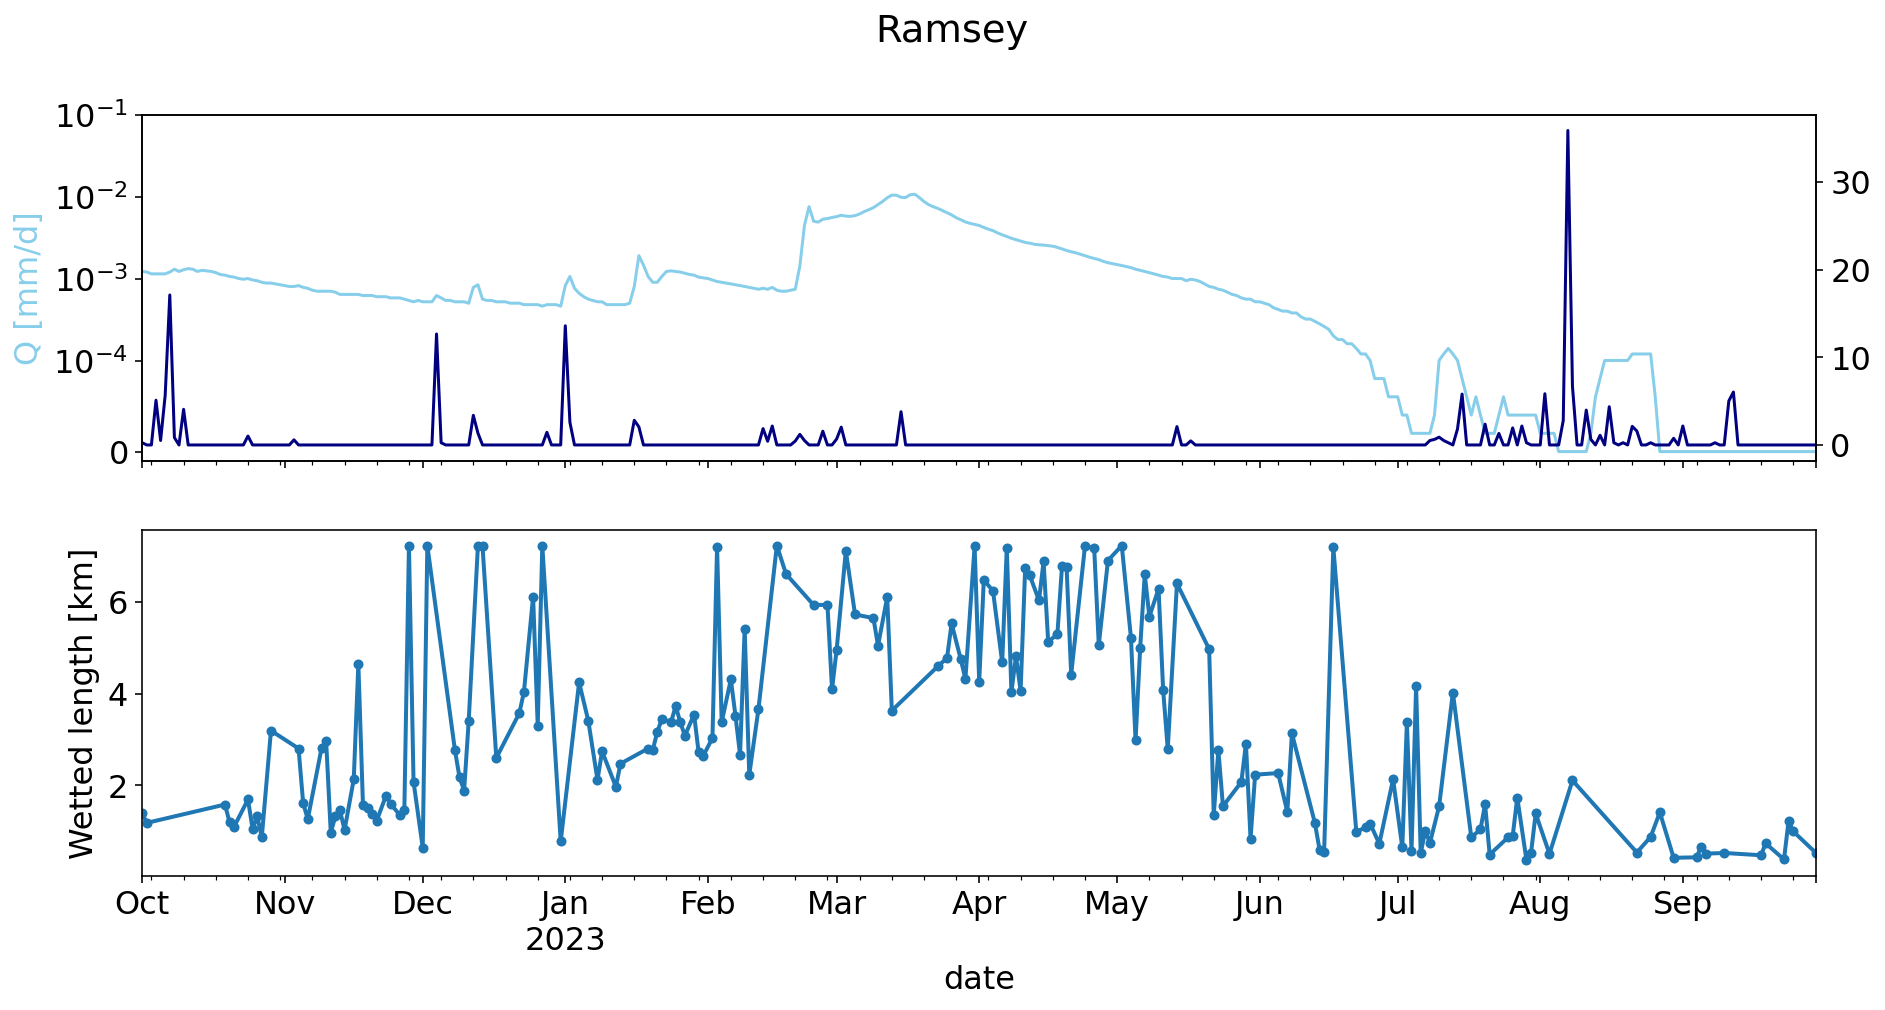

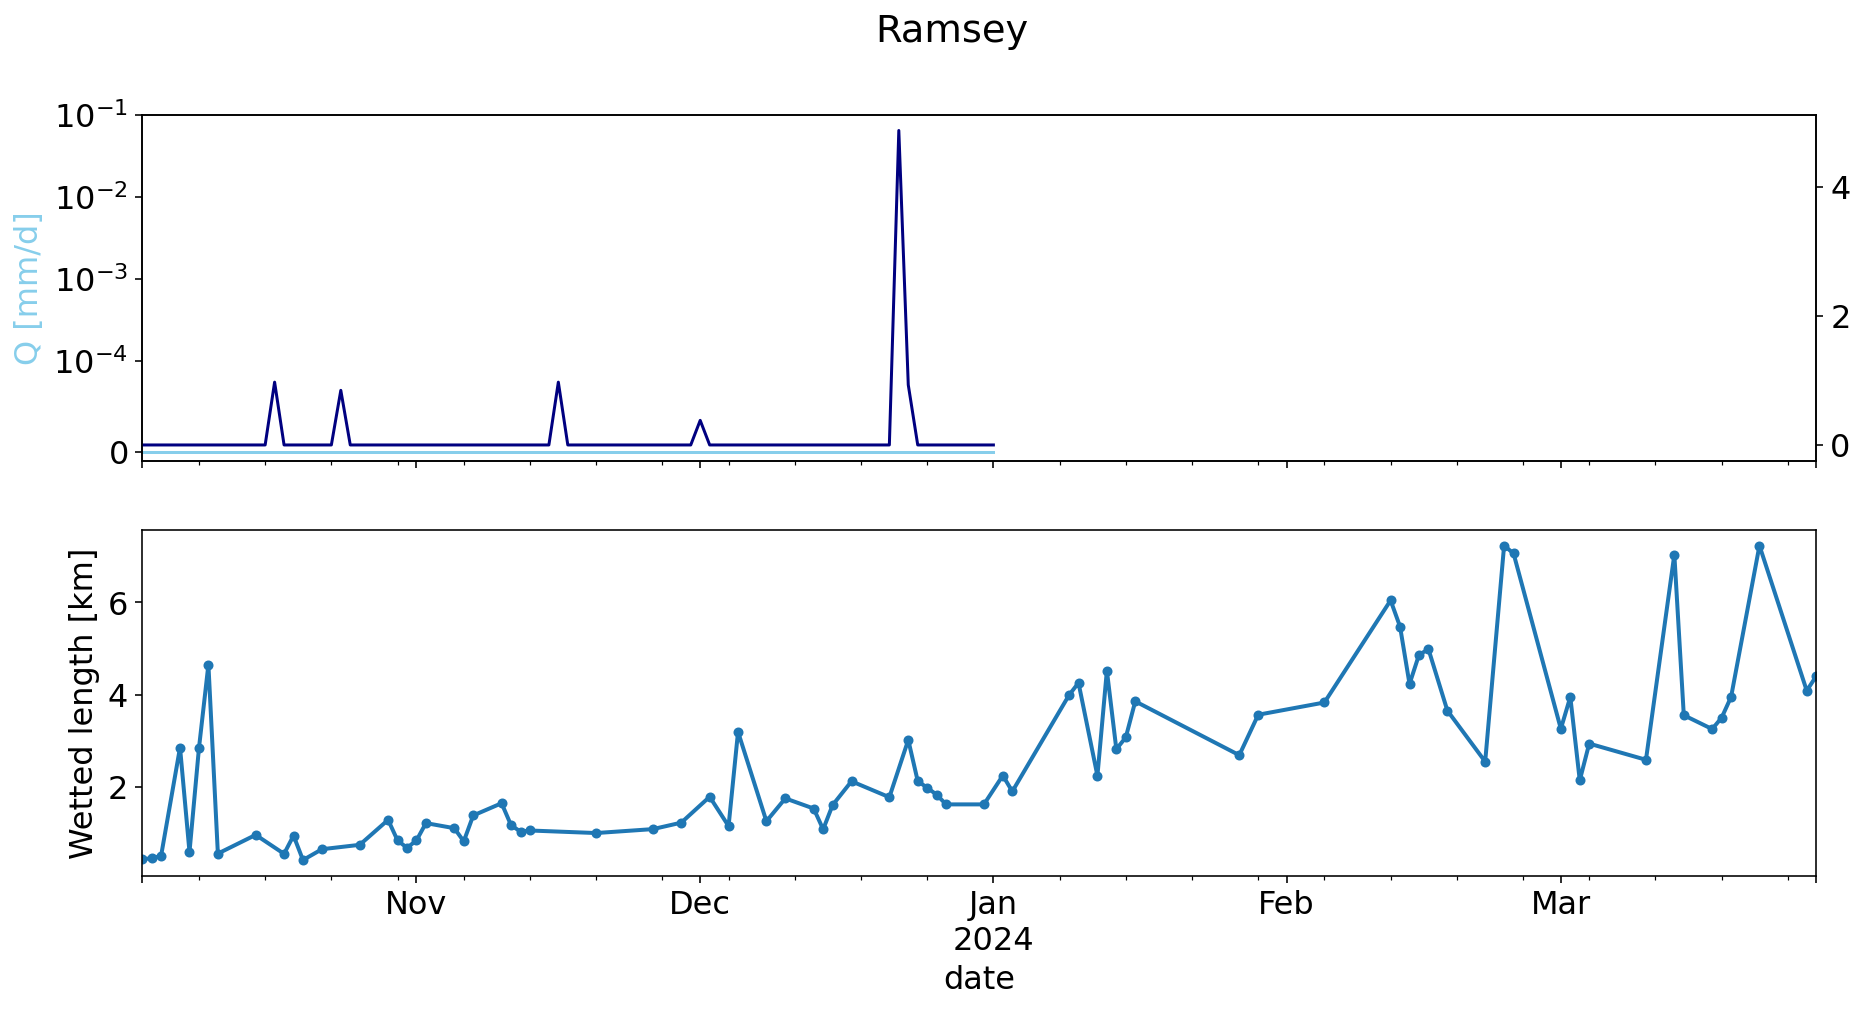

In [547]:
for y in range(2017,2025):
    fig,axs = plt.subplots(2,figsize = (15,7),sharex=True)
    ax = axs[0]
    
    hydro['Q [mm/d]'].loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=ax,c='skyblue')
    ax.set_yscale('symlog',linthresh=0.0001)
    ax.set_ylim(-.00001,0.1)
    ax.set_ylabel('Q [mm/d]',c='skyblue')
    axt = ax.twinx()
    
    hydro['P [mm]'].loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=axt,c='navy')
    # ax

    ax = axs[1]
    (df_alldates.groupby('date').predict.sum()*5/1000).loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=ax,lw=2,marker='o',markersize = 4)
    ax.set_ylabel('Wetted length [km]')

    fig.suptitle(site)

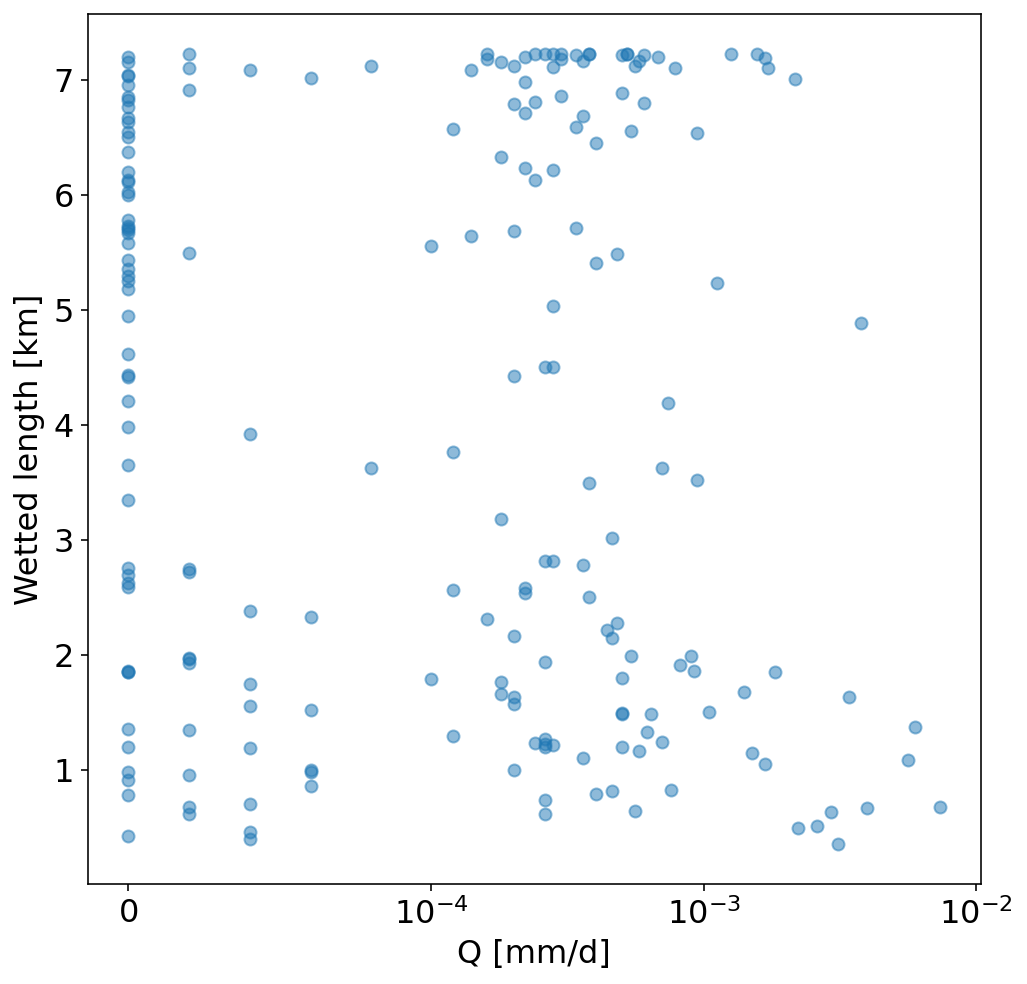

In [548]:
hydroAll = df_alldates.groupby('date')[['predict']].sum().reset_index().merge(hydro,left_on='date',right_index=True)
hydroAll['predict'] = hydroAll.predict*5/1000
hydroAll = hydroAll.loc[:'2023-10-01']

fig,ax = plt.subplots(1,figsize = (8,8))
ax.scatter(hydroAll['Q [mm/d]'],hydroAll.predict,alpha=.5)
ax.set_xlabel('Q [mm/d]')
ax.set_ylabel('Wetted length [km]')
ax.set_xscale('symlog',linthresh=.0001)

<Axes: xlabel='Unnamed: 0'>

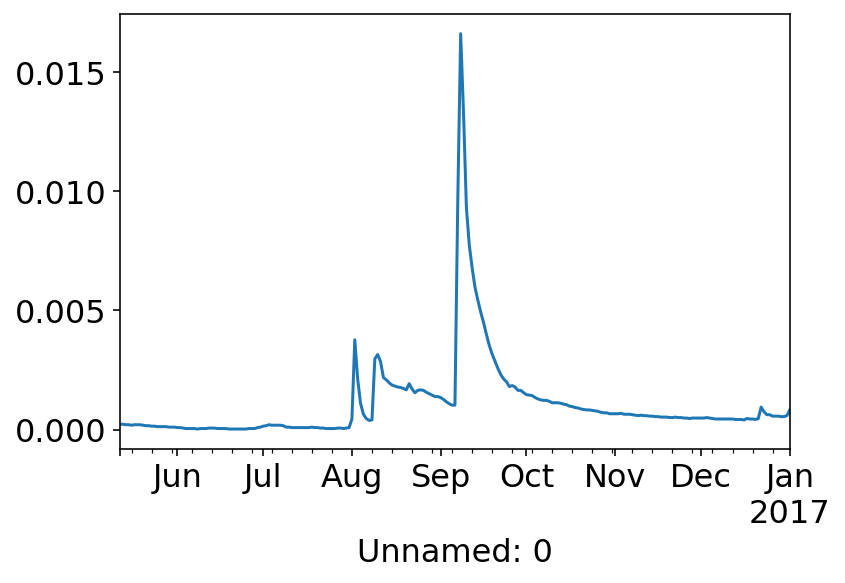

In [549]:
hydroAll[hydroAll['Q [mm/d]']>10e-3]
# hydroAll['Q [mm/d]'].hist(bins = np.logspace(-5,-1,10))
# plt.xscale('log')
hydroAll[hydroAll['Q [mm/d]']==0]#[(hydroAll['Q [mm/d]']<0.00001)&(hydroAll['Q [mm/d]']>0.000001)]
hydro.loc[pd.to_datetime('2016-5-12'):pd.to_datetime('2017-1-1')]['Q [mm/d]'].plot()

In [550]:
df_alldates

geometry       date    blue  \
0        POINT (562487.7694848299 3477326.738673826) 2016-07-22  266.22   
1        POINT (562487.7694848299 3477326.738673826) 2016-08-28  230.56   
2        POINT (562487.7694848299 3477326.738673826) 2016-09-17   47.11   
3        POINT (562487.7694848299 3477326.738673826) 2016-10-19   86.56   
4        POINT (562487.7694848299 3477326.738673826) 2016-11-07   62.22   
...                                              ...        ...     ...   
1654558  POINT (566246.0490671904 3479852.010892204) 2024-03-18  192.67   
1654559  POINT (566246.0490671904 3479852.010892204) 2024-03-19  278.44   
1654560  POINT (566246.0490671904 3479852.010892204) 2024-03-22  398.22   
1654561  POINT (566246.0490671904 3479852.010892204) 2024-03-27  169.67   
1654562  POINT (566246.0490671904 3479852.010892204) 2024-03-28  283.89   

          green     red      NIR  missing  NDWI  p  \
0        502.00  706.78  2630.78        0 -0.68  0   
1        446.00  658.44  2554.89        0 -0.70  0   
2        245.00  394.44  1828.89        0 -0.76  0   
3        295.67  481.33  1593.78        0 -0.69  0   
4        216.11  403.67  1474.67        0 -0.74  0   
...         ...     ...      ...      ...   ... ..   
1654558  459.11  535.89  2154.11        0 -0.65  0   
1654559  567.67  697.78  2672.33        0 -0.65  0   
1654560  679.56  816.44  2447.33        0 -0.57  0   
1654561  473.67  618.78  2476.56        0 -0.68  0   
1654562  551.89  678.44  2649.11        0 -0.66  0   

                                acquired  satellite_azimuth satellite_id  \
0       2016-07-22 17:10:51.461035+00:00              170.1         0e20   
1       2016-08-28 17:12:07.576904+00:00              173.1         0e20   
2       2016-09-17 17:13:09.998412+00:00              229.8         0e0d   
3       2016-10-19 17:13:45.111834+00:00              186.0         0e20   
4       2016-11-07 17:14:29.062402+00:00              185.4         0e2f   
...                                  ...                ...          ...   
1654558 2024-03-18 17:15:41.800896+00:00              101.5         24b4   
1654559 2024-03-19 18:09:34.407650+00:00              101.7         24cd   
1654560 2024-03-22 17:18:09.982769+00:00              262.8         24c0   
1654561 2024-03-27 18:07:50.926206+00:00              277.2         2484   
1654562 2024-03-28 17:20:36.187981+00:00              277.1         24c9   

         sun_azimuth  sun_elevation  view_angle  doy  time  predict  
0              101.5           57.4         2.9  204    17        1  
1              119.0           52.7         0.8  241    17        0  
2              129.4           48.8         0.8  261    17        0  
3              142.6           40.5         0.8  293    17        1  
4              147.1           35.3         0.2  312    17        0  
...              ...            ...         ...  ...   ...      ...  
1654558        129.3           45.2         3.1   78    17        1  
1654559        145.7           53.5         3.5   79    18        1  
1654560        128.3           46.7         0.6   82    17        1  
1654561        142.3           55.8         5.0   87    18        1  
1654562        126.7           48.8         4.7   88    17        1  

[1654563 rows x 18 columns]

In [551]:
df_alldates['x'] = df_alldates['geometry'].apply(lambda x: float(x.split()[1][1:]))
df_alldates['y'] = df_alldates['geometry'].apply(lambda y: float(y.split()[2][:-1]))
df_alldates = gpd.GeoDataFrame(
    df_alldates, geometry=gpd.points_from_xy(df_alldates.x,df_alldates.y), crs="EPSG:26912"
)
df_alldates = df_alldates.to_crs('EPSG:4326')
df_alldates['x'] = df_alldates.geometry.x
df_alldates['y'] = df_alldates.geometry.y

In [552]:
df_alldates[(df_alldates.date<pd.to_datetime('2016-12-15'))&
           (df_alldates.date>pd.to_datetime('2016-9-12'))].date.unique()#.columns#[['date','Q [mm/d]']]

<DatetimeArray>
['2016-09-17 00:00:00', '2016-10-19 00:00:00', '2016-11-07 00:00:00',
 '2016-11-12 00:00:00', '2016-11-15 00:00:00', '2016-11-23 00:00:00',
 '2016-11-24 00:00:00', '2016-11-05 00:00:00']
Length: 8, dtype: datetime64[ns]

In [553]:
df_alldates['wet'] = df_alldates.predict

L = 9%
L = 27%
L = 18%
L = 16%


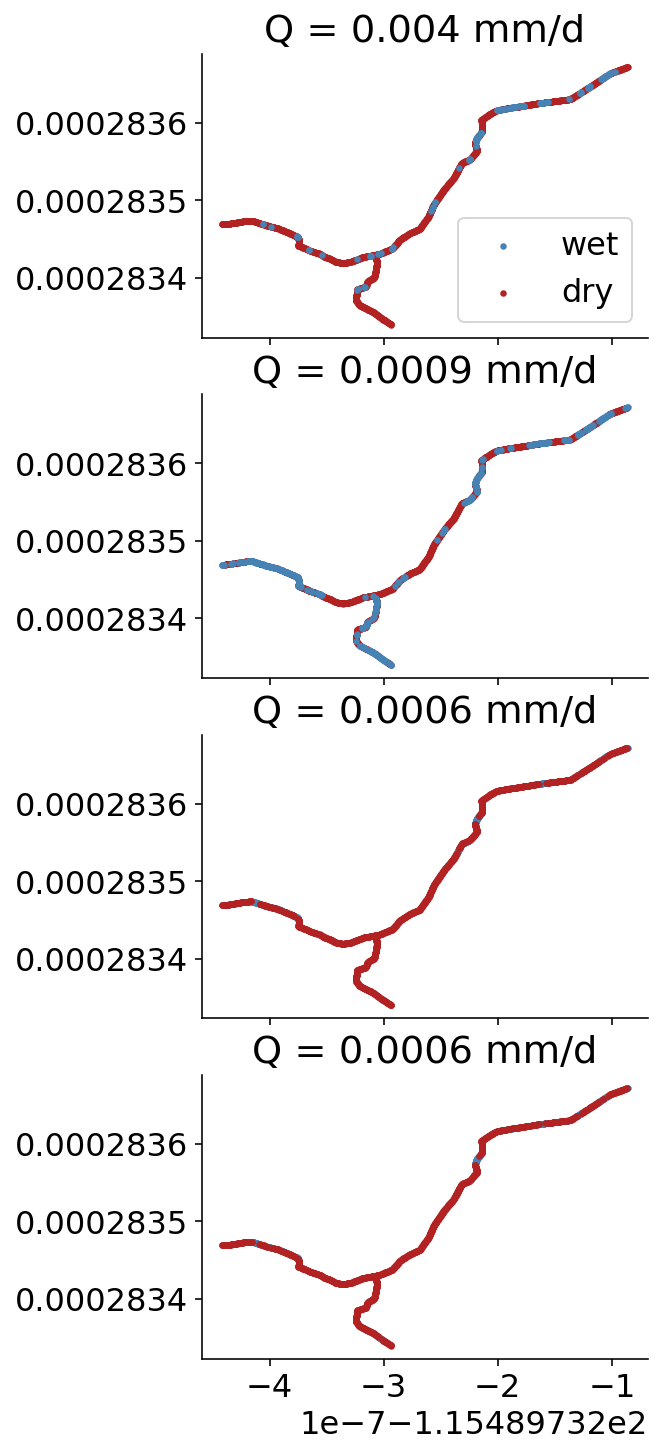

In [554]:
import matplotlib as mpl
import geopandas as gpd

size = 5

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(4,figsize = (4,12),
                       sharex=True,
                       sharey=True)


xv,yv = -110.31,31.425

i=0
for date in ['2016-09-17','2016-10-19',
            '2016-11-07','2016-11-12',]:#subset.date.drop_duplicates().values[:4]:
  dfsub = df_alldates[df_alldates.date==date]
  if date=='2018-02-12':
    dfsub = dfsub[dfsub.area_updated<=20000]
  dfsub = dfsub.drop_duplicates()
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

  ax = axs[i]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
#   ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ddate = dfsub.merge(hydro,left_on='date',right_index=True)
  ax.set_title('Q = '+str(round(ddate['Q [mm/d]'].values[0],4))+' mm/d')
#   ax.text(-1*(1e-7-1.154897e2),.00028335,'L = '+str(round((len(dfsub)-len(dfsub2))/len(dfsub))*100)+'%')
  print('L = '+str(round(len(dfsub[dfsub.wet==1])/len(dfsub)*100))+'%')
    


  n = 70

  i+=1



# axs[0,0].text(xv-.015,yv+.03,'Actual',
#               ha = 'center',fontsize = 16)
# axs[0,1].text(xv-.015,yv+.03,'Predicted',
#               ha = 'center',fontsize = 16)
# axs[0,2].text(xv-.015,yv+.03,'Comparison',
#               ha = 'center',fontsize = 16)

# labels = ['a)','b)','c)',
#           'd)','e)','f)',
#           'g)','h)','i)',
#           'j)','k)','l)']

# k=0
# for i in range(4):
#   for j in range(3):
#     axs[i,j].text(-123.517,39.579,labels[k],
#                   fontsize = 16)
#     # print(i,j,k)
#     k+=1

# ax = axs[3,0]
# labels = [item.get_text() for item in ax.get_xticklabels()]
# for ax in [axs[3,0],axs[3,1],axs[3,2]]:
#   ax.set_xticklabels(labels,rotation=90)
#   ax.set_xlabel('Longitude')

# for ax in [axs[0,0],axs[1,0],axs[2,0]]:
#   ax.set_ylabel('Latitude')

# plt.savefig('training_maps.pdf',format='pdf',bbox_inches='tight')

## Context Space

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/3128773481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['month'] = context.acquired.dt.month
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/3128773481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['date'] = pd.to_datetime(context.date)


array([[<Axes: title={'center': 'wet'}>,
        <Axes: title={'center': 'satellite_azimuth'}>,
        <Axes: title={'center': 'sun_azimuth'}>],
       [<Axes: title={'center': 'sun_elevation'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'Q [mm/d]'}>],
       [<Axes: title={'center': 'P [mm]'}>, <Axes: >, <Axes: >]],
      dtype=object)

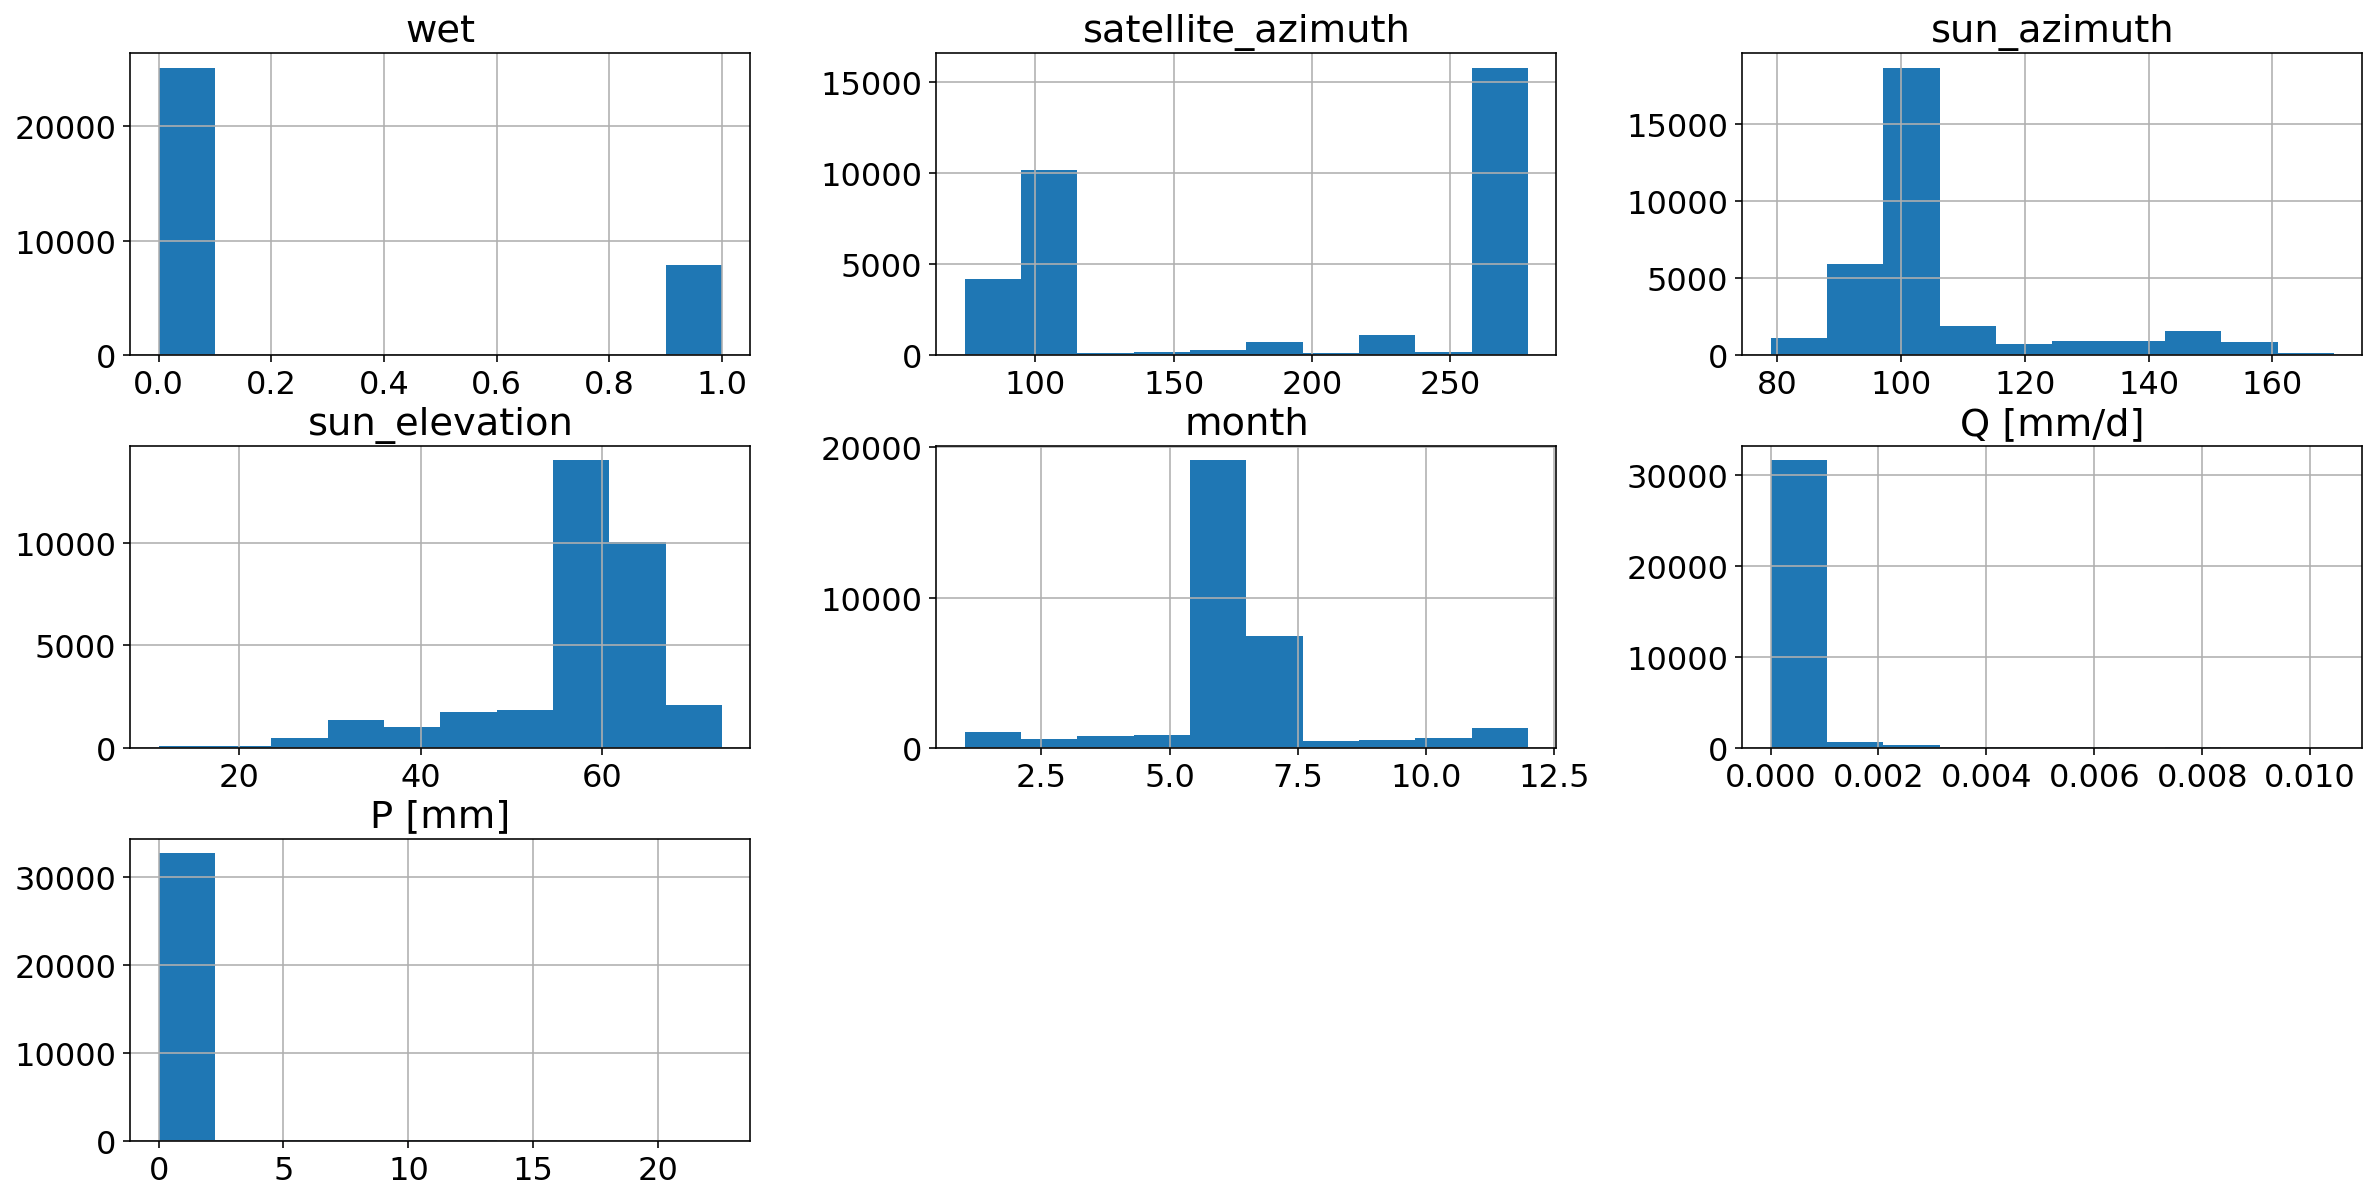

In [555]:
context = df[['date','wet','acquired','satellite_azimuth','satellite_id','sun_azimuth','sun_elevation',
#    'view_angle','time'
             ]]
context['month'] = context.acquired.dt.month
context['date'] = pd.to_datetime(context.date)
context = context.merge(hydro,left_on='date',right_index=True)
context.drop(columns=['date','acquired','satellite_id'],inplace=True)
context.hist(figsize = (20,10))

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/3694956158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['month'] = context.acquired.dt.month
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/3694956158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['date'] = pd.to_datetime(context.date)


array([[<Axes: title={'center': 'wet'}>,
        <Axes: title={'center': 'satellite_azimuth'}>,
        <Axes: title={'center': 'sun_azimuth'}>],
       [<Axes: title={'center': 'sun_elevation'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'Q [mm/d]'}>],
       [<Axes: title={'center': 'P [mm]'}>, <Axes: >, <Axes: >]],
      dtype=object)

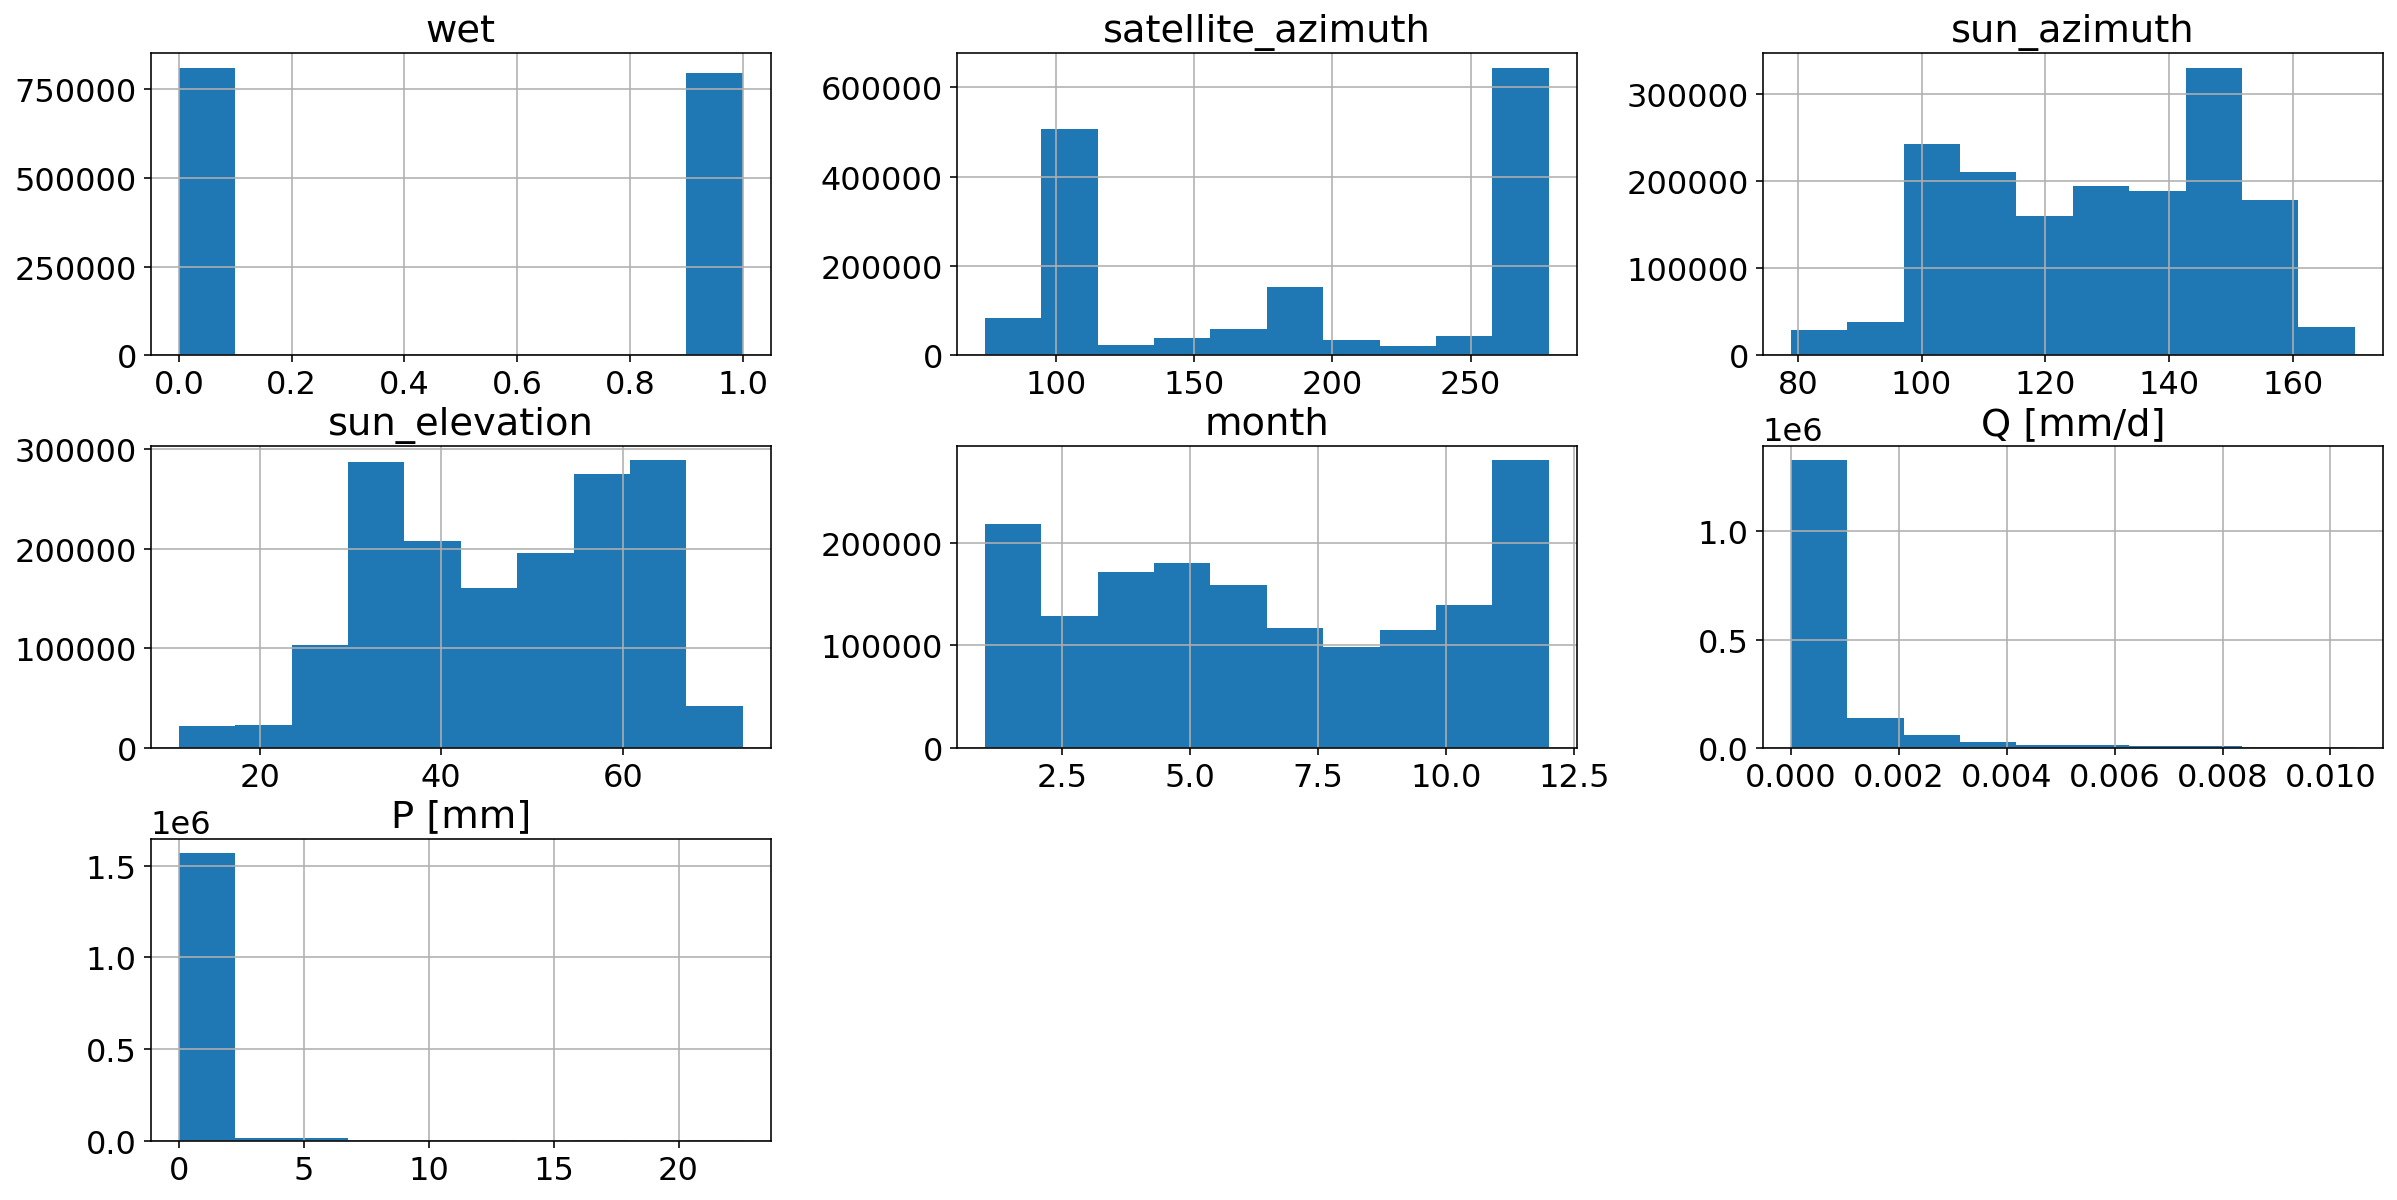

In [556]:
context = df_alldates[['date','wet','acquired','satellite_azimuth','satellite_id','sun_azimuth','sun_elevation',
#    'view_angle','time'
                      ]]
context['month'] = context.acquired.dt.month
context['date'] = pd.to_datetime(context.date)
context = context.merge(hydro,left_on='date',right_index=True)
context.drop(columns=['date','acquired','satellite_id'],inplace=True)
context.hist(figsize = (20,10))

## next section

In [136]:
df_alldates1 = df_alldates.drop(columns='geometry')
df_alldates1['datetime'] = df_alldates.date
df_alldates1 = df_alldates1.merge(hydro,left_on='datetime',right_index=True)

dryvals = df_alldates1[df_alldates1.predict==0]
dryvals['datetime'] = pd.to_datetime(dryvals.datetime)
dryvals = dryvals.groupby('datetime').mean()
wetvals = df_alldates1[df_alldates1.predict==1]
wetvals['datetime'] = pd.to_datetime(wetvals.datetime)
wetvals = wetvals.groupby('datetime').mean()
plt.figure(figsize = (20,10))
plt.scatter(dryvals['Q [mm/d]'],dryvals.tree_agreement, c='firebrick',
            label = 'Dry labels')
plt.scatter(wetvals['Q [mm/d]'],wetvals.tree_agreement, c='steelblue',
            label = 'Wet labels')
plt.ylabel('Intertree agreement')
plt.legend()
plt.xscale('symlog')
plt.xlabel('Runoff [mm/d]')

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/2633614924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryvals['datetime'] = pd.to_datetime(dryvals.datetime)
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/2633614924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wetvals['datetime'] = pd.to_datetime(wetvals.datetime)


AttributeError: 'DataFrame' object has no attribute 'tree_agreement'

<Figure size 1440x720 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


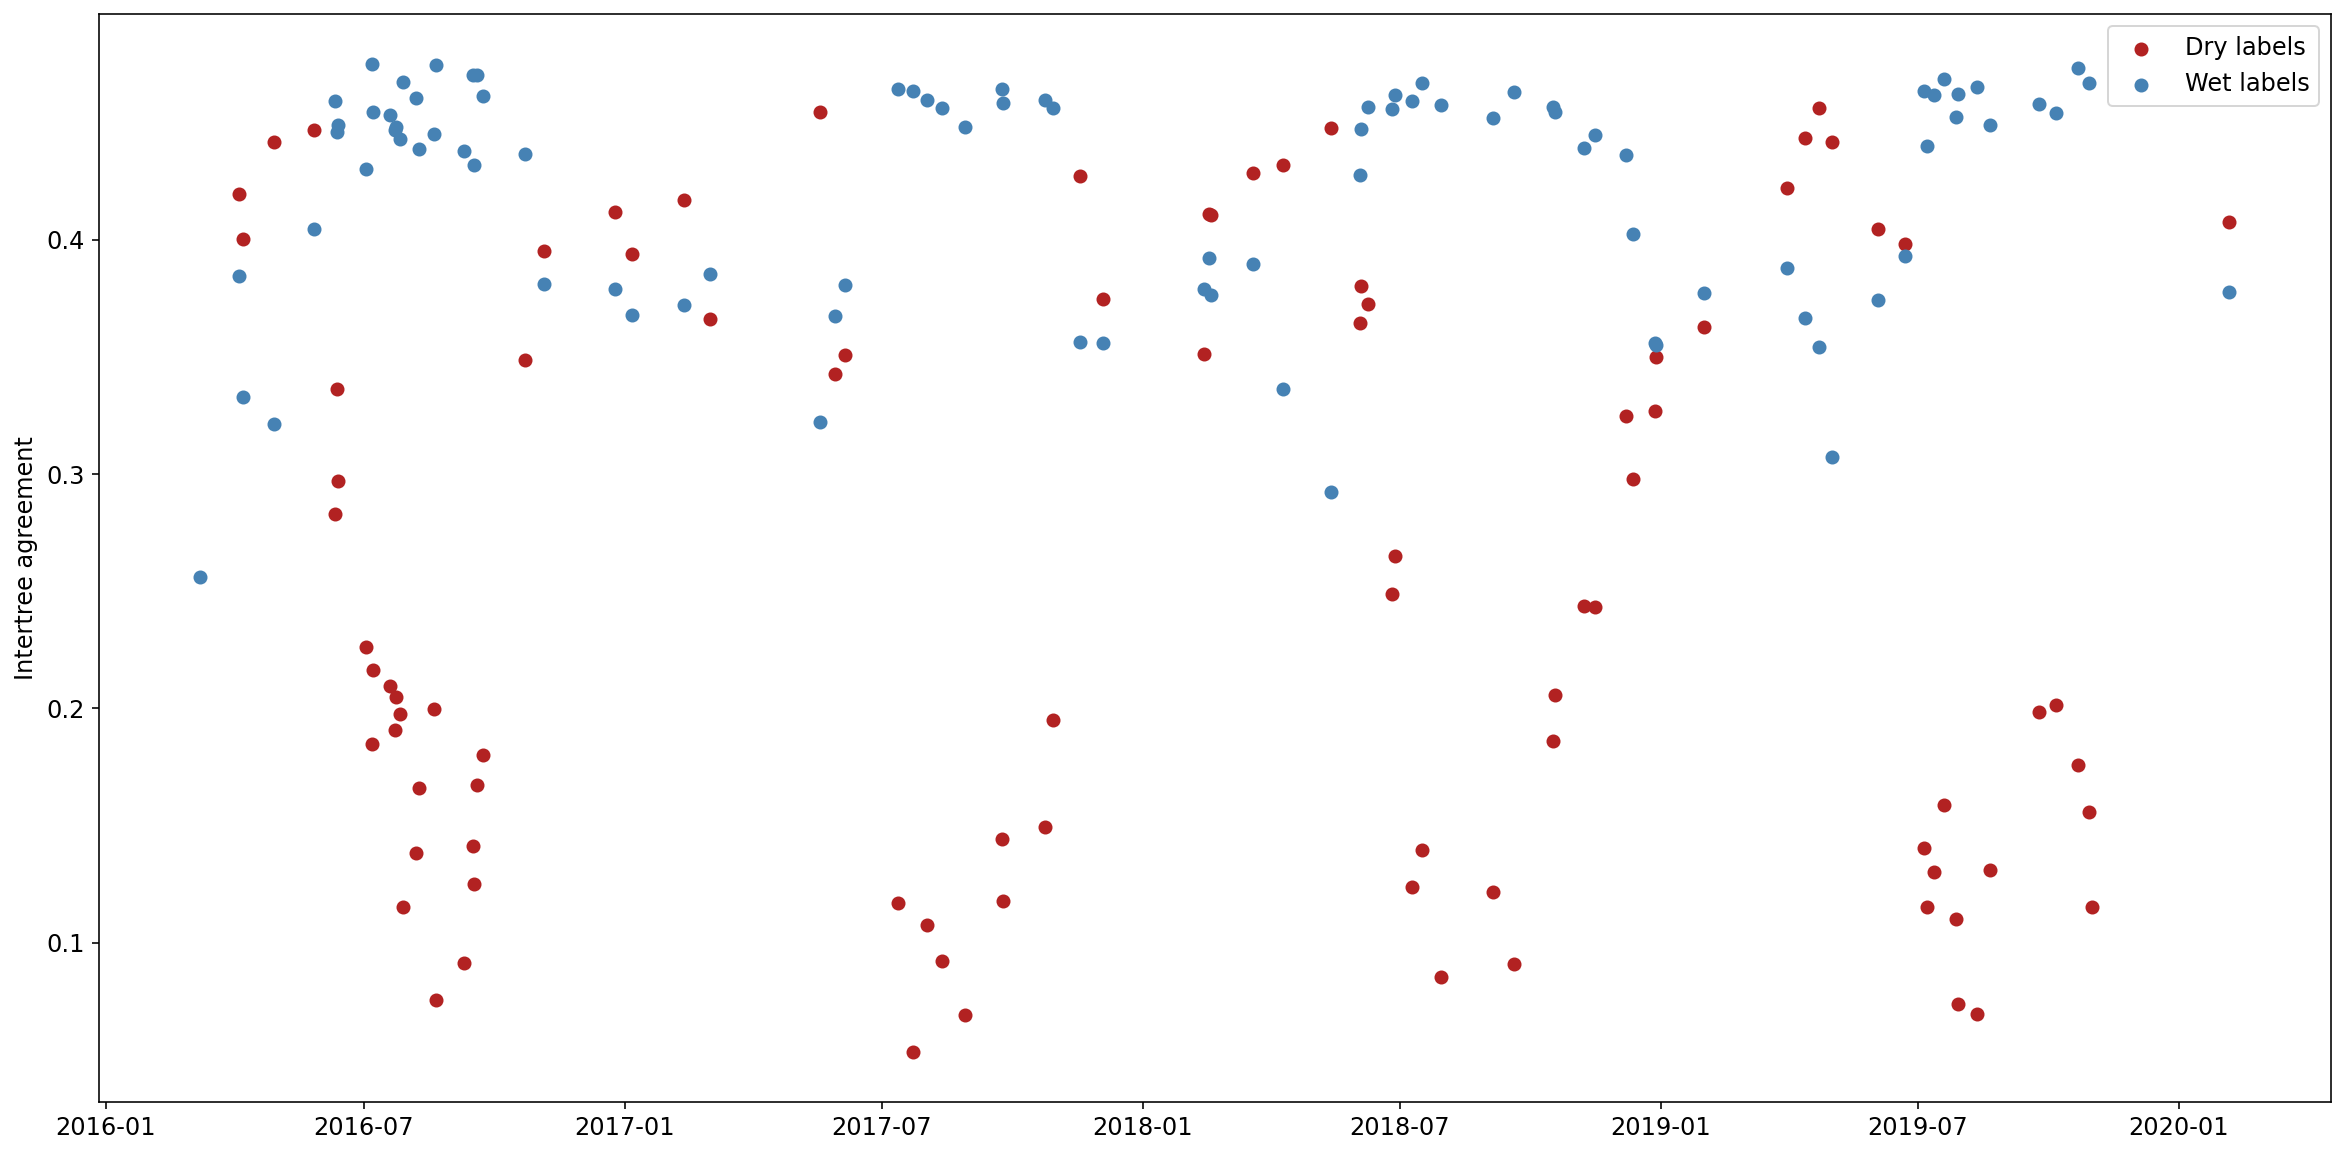

In [ ]:
df_alldates.columns
dryvals = df_alldates[df_alldates.predict==0]
dryvals['datetime'] = pd.to_datetime(dryvals.datetime)
dryvals = dryvals.groupby('datetime').mean()
wetvals = df_alldates[df_alldates.predict==1]
wetvals['datetime'] = pd.to_datetime(wetvals.datetime)
wetvals = wetvals.groupby('datetime').mean()
plt.figure(figsize = (20,10))
plt.scatter(dryvals.index,dryvals.tree_agreement, c='firebrick',
            label = 'Dry labels')
plt.scatter(wetvals.index,wetvals.tree_agreement, c='steelblue',
            label = 'Wet labels')
plt.ylabel('Intertree agreement')
plt.legend()

In [ ]:
# dry_runoff = dry_runoff.reset_index()
# dry_runoff['index'] = pd.to_datetime(dry_runoff['index'])
df_alldates['date'] = pd.to_datetime(df_alldates.date)
df_alldates = df_alldates.drop_duplicates()
dry_runoff = dry_runoff.drop_duplicates()
df_alldates1 = df_alldates.merge(dry_runoff,left_on='date',
                                 right_index=True)

In [ ]:
df_alldates['tree_agreement'] = pred_list.std(axis=1)

In [ ]:
pred_list = np.empty([len(subdf4),n_est])
for i in np.arange(n_est):
  pred_list[:,i] = model.estimators_[i].predict(subdf4[features])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

In [ ]:
subdf4 = df_alldates[df_alldates['datetime']>'2016']
n_est = 100
dates = np.unique(subdf4.datetime)

date_std = np.empty([len(dates),2],dtype=object)

for j,date in enumerate(dates):
  print(date)
  subdf5 = subdf4[subdf4.datetime==date]
  subdf5.replace(np.inf, subdf5.median(), inplace=True)
  subdf5.fillna(subdf5.median(), inplace=True)
  pred_list = np.empty([len(subdf5),n_est])


  for i in np.arange(n_est):
    pred_list[:,i]=(model.estimators_[i].predict(subdf5[features]))

  date_std[j,0] = str(date)
  date_std[j,1] = pred_list.std(axis=1).mean()

2016-03-07 19:46:35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-04-03 19:58:29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2016-04-06 19:39:41


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-04-28 19:39:41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-05-26 19:54:01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-06-10 19:41:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-06-11 19:42:02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-06-12 19:45:38


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-02 19:47:30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-06 19:48:52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-07 19:52:09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-19 19:39:01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-22 19:49:54


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-23 19:43:23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-26 19:50:34


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-28 19:28:03


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-08-06 19:37:05


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-08-08 19:40:59


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-08-19 19:53:32


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-08-20 19:30:43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-09 19:28:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2016-09-15 19:37:19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-16 19:40:31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-18 19:37:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-22 19:49:32


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-10-22 19:29:29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-11-04 19:49:43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-12-24 19:29:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-01-05 19:48:10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-02-11 19:42:39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-03-01 19:37:51


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

2017-05-18 19:41:51


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-05-28 19:22:56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-06-04 19:33:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-07-12 19:31:56


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-07-22 19:25:39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-08-01 19:35:52


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-08-12 19:21:20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-08-28 19:21:55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-09-23 19:34:16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-09-24 19:26:14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-10-23 19:17:48


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-10-29 19:26:31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-11-17 19:26:35


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-12-03 19:29:05


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-02-12 19:23:30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-02-16 19:25:13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-02-17 19:28:31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-03-19 19:12:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-04-09 19:19:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-05-13 19:16:35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-02 19:07:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-03 19:10:29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-06-08 19:15:23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-25 19:20:21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-06-27 19:14:45


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-07-09 19:14:45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-07-16 19:14:04


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-07-29 19:05:52


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-09-04 19:12:24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-09-19 18:58:38


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-10-16 19:11:59


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-10-18 19:07:22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-11-07 19:09:04


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-11-15 18:55:41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-12-07 19:03:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-12-12 19:08:32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-12-27 19:06:23


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

2018-12-28 18:58:17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-01-31 18:53:55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-03-30 18:52:44


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-04-12 19:01:36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-04-22 19:01:28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-05-01 18:56:37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-06-02 18:52:13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-06-21 18:52:00


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-07-05 18:50:21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-07-07 18:38:53


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-07-12 18:44:54


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-07-19 18:47:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-07-27 18:49:44


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-07-29 18:36:39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-08-11 18:34:48


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-08-20 18:46:12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-09-24 18:41:16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-10-06 18:39:15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2019-10-21 18:36:12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-10-29 18:46:45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-10-31 18:40:16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2020-02-05 18:38:47


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

Check intertree agreement by date

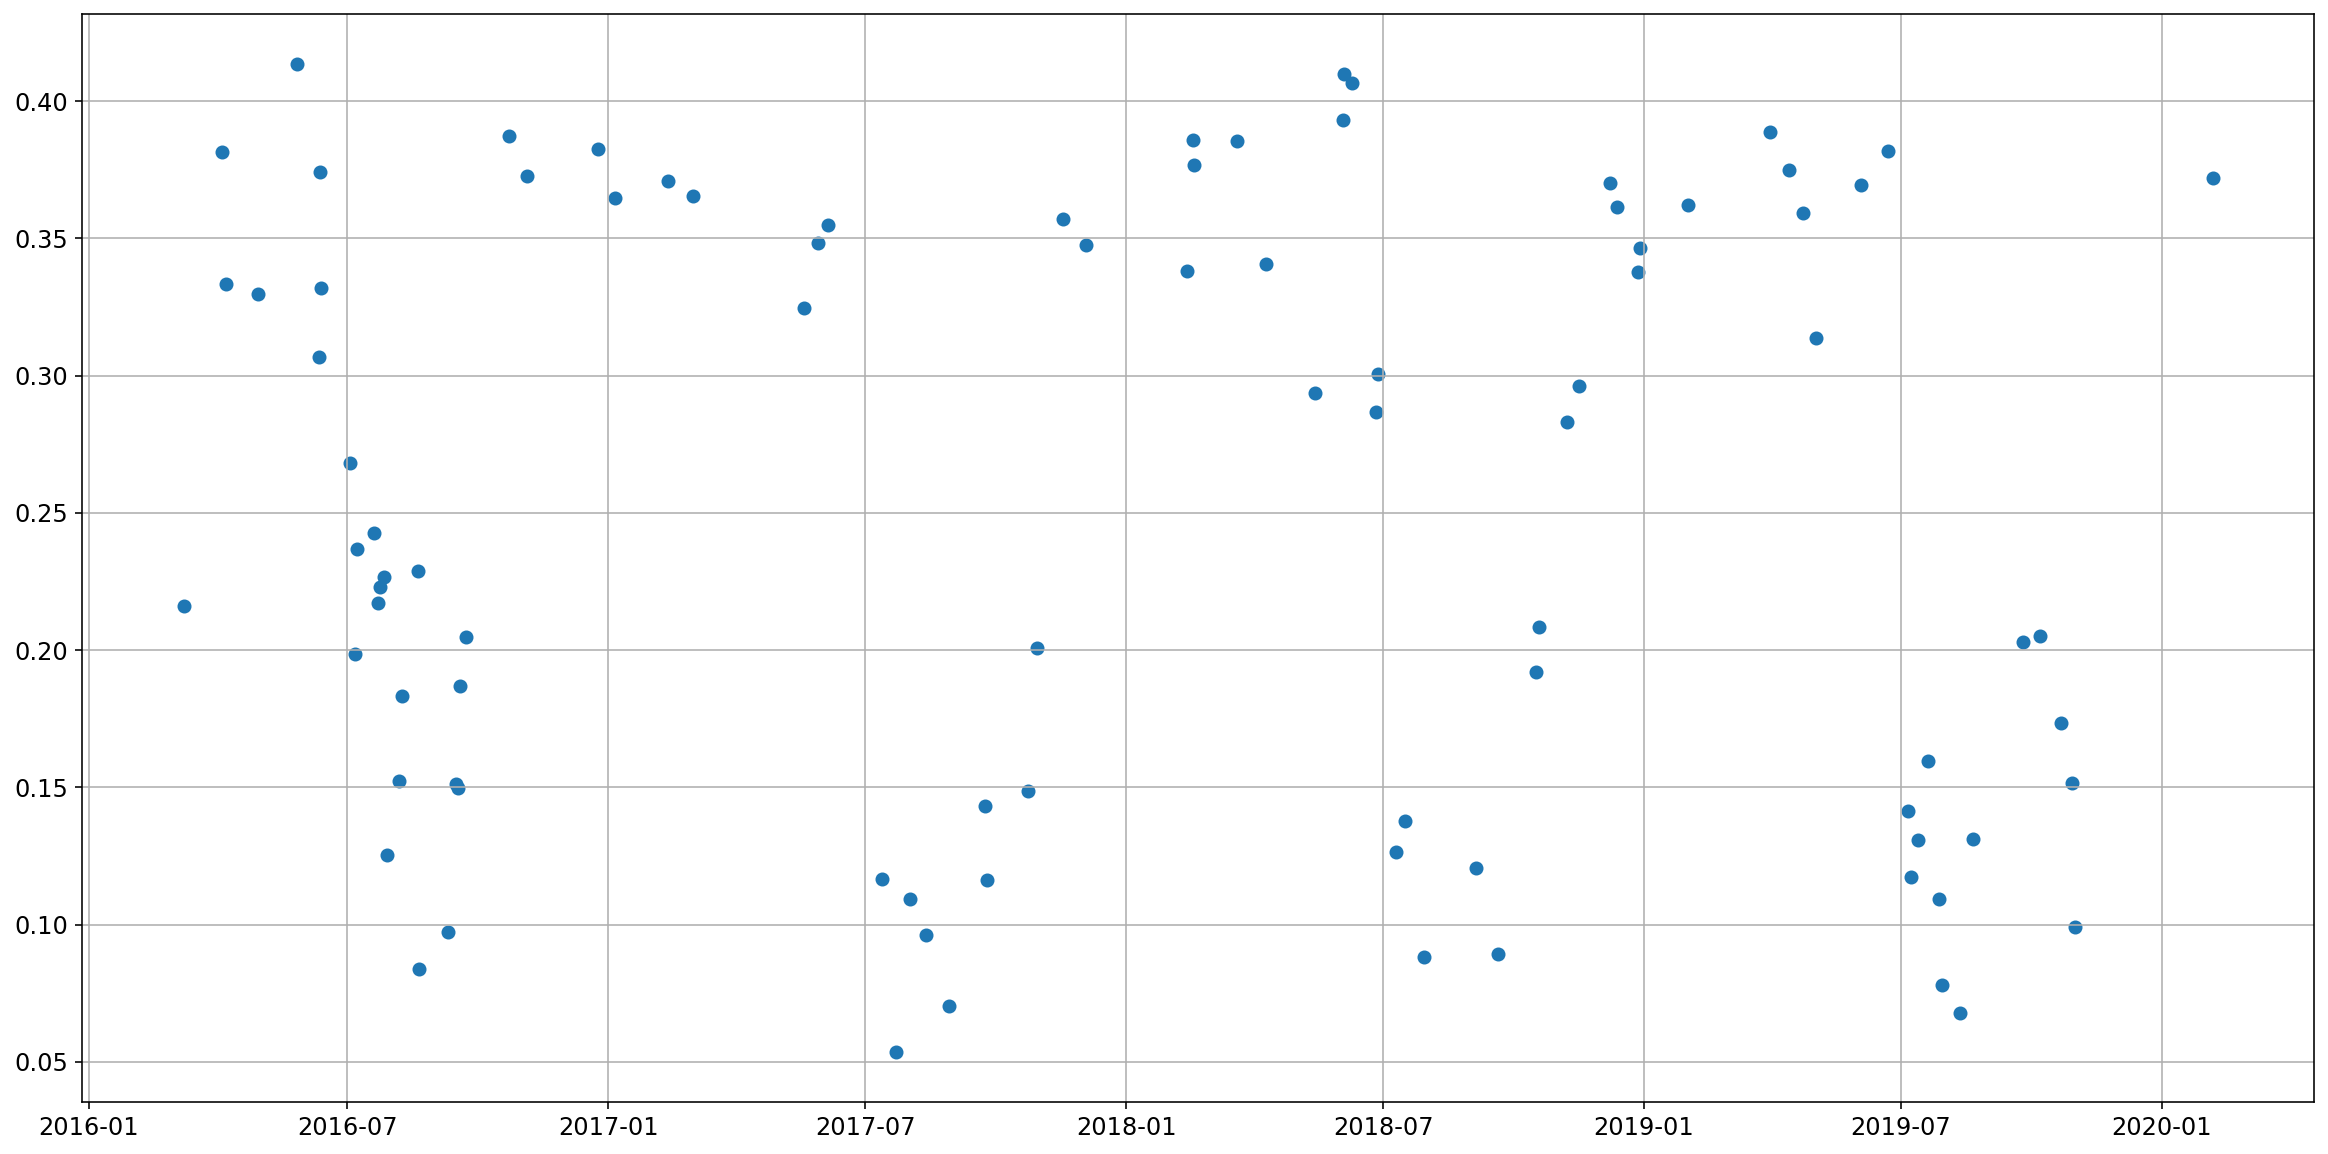

In [ ]:
# plt.figure(figsize = (20,10))
std_df = pd.DataFrame(date_std,columns=['Date','mean std'])
std_df['Date'] = pd.to_datetime(std_df['Date'])
ax,fig=plt.subplots(figsize=(20,10))
plt.scatter(std_df.Date,std_df['mean std'])
plt.grid()

In [ ]:
subdf4 = df_alldates[df_alldates['datetime']>'2016']
n_est = 100
dates = np.unique(subdf4.datetime)

date_std = np.empty([len(dates),2],dtype=object)

for j,date in enumerate(dates):
  print(date)
  subdf5 = subdf4[subdf4.datetime==date]
  subdf5.replace(np.inf, subdf5.median(), inplace=True)
  subdf5.fillna(subdf5.median(), inplace=True)
  pred_list = np.empty([len(subdf5),n_est])


  for i in np.arange(n_est):
    pred_list[:,i]=(model.estimators_[i].predict(subdf5[features]))

  date_std[j,0] = str(date)
  date_std[j,1] = pred_list.std(axis=1).mean()

2016-03-07 19:46:35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-04-03 19:58:29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-04-06 19:39:41


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-04-28 19:39:41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-05-26 19:54:01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-06-10 19:41:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-06-11 19:42:02


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-06-12 19:45:38


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-02 19:47:30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-06 19:48:52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-07 19:52:09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-19 19:39:01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-22 19:49:54


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-23 19:43:23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-07-26 19:50:34


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-07-28 19:28:03


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-08-06 19:37:05


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-08-08 19:40:59


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-08-19 19:53:32


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-08-20 19:30:43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-09 19:28:58


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-09-15 19:37:19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-16 19:40:31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-18 19:37:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-09-22 19:49:32


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2016-10-22 19:29:29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-11-04 19:49:43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2016-12-24 19:29:46


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

2017-01-05 19:48:10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-02-11 19:42:39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-03-01 19:37:51


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-05-18 19:41:51


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-05-28 19:22:56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-06-04 19:33:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-07-12 19:31:56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2017-07-22 19:25:39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-08-01 19:35:52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2017-08-12 19:21:20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-08-28 19:21:55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-09-23 19:34:16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-09-24 19:26:14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-10-23 19:17:48


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2017-10-29 19:26:31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2017-11-17 19:26:35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2017-12-03 19:29:05


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-02-12 19:23:30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-02-16 19:25:13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-02-17 19:28:31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-03-19 19:12:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-04-09 19:19:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-05-13 19:16:35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-02 19:07:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-03 19:10:29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-06-08 19:15:23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-25 19:20:21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-06-27 19:14:45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-07-09 19:14:45


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-07-16 19:14:04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-07-29 19:05:52


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2018-09-04 19:12:24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-09-19 18:58:38


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-10-16 19:11:59


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-10-18 19:07:22


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

2018-11-07 19:09:04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-11-15 18:55:41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-12-07 19:03:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-12-12 19:08:32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2018-12-27 19:06:23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2018-12-28 18:58:17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-01-31 18:53:55


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-03-30 18:52:44


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-04-12 19:01:36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-04-22 19:01:28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-05-01 18:56:37


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-06-02 18:52:13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-06-21 18:52:00


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-07-05 18:50:21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-07-07 18:38:53


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2019-07-12 18:44:54


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-07-19 18:47:46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2019-07-27 18:49:44


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-07-29 18:36:39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-08-11 18:34:48


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-08-20 18:46:12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2019-09-24 18:41:16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2019-10-06 18:39:15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2019-10-21 18:36:12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but

2019-10-29 18:46:45


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

2019-10-31 18:40:16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before cal

2020-02-05 18:38:47


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

#Check intertree agreement by date

In [ ]:
# # uncomment to save

# df_alldates.to_csv('/content/drive/MyDrive/Sky_Data/rf_predictions.csv')